In [1]:
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import pandas as pd
import re

import time
import torch
import torch.nn

import random
import pickle


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
4
Tesla V100-SXM2-32GB


In [3]:
import torch.backends.cudnn as cudnn
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
else:
    device = torch.device("cpu")
    cudnn.benchmark=False

print(device)
print(torch.cuda.get_device_name(0))

cuda:0
Tesla V100-SXM2-32GB


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 1. Load model

In [5]:
### remove nan values
def remove_nan(y):
    nan_idx = np.where(pd.isna(y))[0]
    return y.drop(y.index[nan_idx], axis=0)

In [6]:
### Discretize the continuous variables into 2 or 3 categories - low, (moderate), high
def if_discretize(y_nonan):
    if y_nonan.dtype.name == 'object':
        y_disc = y_nonan
    elif len(np.unique(y_nonan)) <= 6:
        y_disc = y_nonan
    elif np.quantile(y_nonan, 1/2)==np.min(y_nonan):
        y_disc = pd.Series(np.where(y_nonan==np.min(y_nonan), 'Min', 'Not Min'), index=y_nonan.index)
    elif np.quantile(y_nonan, 1/2)==np.max(y_nonan):
        y_disc = pd.Series(np.where(y_nonan==np.max(y_nonan), 'Not Max', 'Max'), index=y_nonan.index)
    elif np.quantile(y_nonan, 1/3)==np.min(y_nonan) or np.quantile(y_nonan, 2/3)==np.max(y_nonan):
        y_disc = pd.qcut(y_nonan, 2, labels=['Low', 'High'])
    else:
        y_disc = pd.qcut(y_nonan, 3, labels=['Low', 'Moderate', 'High'])
    
    ### remove categories with less than 5 instances (8/2 training/testing split)
    u, c = np.unique(y_disc, return_counts=True)
    idx = np.where(np.isin(y_disc, u[c<5]))
    return y_disc.drop(index=y_disc.index[idx])

In [7]:
def balanced_over_sampling(X, y, random_seed=123):
    np.random.seed(random_seed)
    unique_value, unique_value_counts = np.unique(y, return_counts=True)
    train_class_max = np.max(unique_value_counts)
    train_samples_idx = []
    for i, y_unique in enumerate(unique_value):
        train_one_class_idx = np.where(y==y_unique)[0]
        train_one_sample_idx = np.concatenate([train_one_class_idx,
                                               np.random.choice(train_one_class_idx, 
                                                                size=train_class_max-len(train_one_class_idx), replace=True)])
        train_samples_idx.append(train_one_sample_idx)
    train_balanced_idx = np.random.permutation(np.concatenate(train_samples_idx))
    return X[train_balanced_idx], y[train_balanced_idx]

In [8]:
class Classifier(torch.nn.Module):
    def __init__(self, n_in_features, net_hidden_structure, n_out_features, dropout_rate):
        super(Classifier, self).__init__()
        net_fcs = []
        structure = net_hidden_structure
        net_in_shape = n_in_features
        for i, net_n_hidden_nodes in enumerate(structure):
            net_fcs.append(torch.nn.Linear(net_in_shape, net_n_hidden_nodes))
            net_fcs.append(torch.nn.BatchNorm1d(net_n_hidden_nodes))
            net_fcs.append(torch.nn.ReLU6())
            net_fcs.append(torch.nn.Dropout(p=dropout_rate))
            net_in_shape = net_n_hidden_nodes
        net_fcs.append(torch.nn.Linear(net_in_shape, n_out_features))
        self.net_fcs = torch.nn.ModuleList(net_fcs)
        
    def forward(self, x):
        net_fcs = self.net_fcs
        for net_fc in net_fcs:
            x = net_fc(x)
        return x

In [9]:
from torch.utils.data import Dataset, DataLoader
class Dataset(Dataset):
    """Self-defined dataset."""

    def __init__(self, X, y):
        """
        Args:
            X: microbiome data
            y: response data
        """
        self.X = torch.from_numpy(X).float() if not torch.is_tensor(X) else X.float()
        self.y = torch.LongTensor(y) if not torch.is_tensor(y) else y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
def load_model(X,y, disease, dropout_rate, weight_decay,
              lr=0.001, momentum=0.9, random_state=123, device='cuda:0', print_loss=True,
              save_folder='./'):
    
    import torch
    import torch.nn as nn
    import random
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        
    ###
    y_nonan = remove_nan(y)
    y_nonan_disc = if_discretize(y_nonan)
    X_nonan = X.loc[y_nonan_disc.index,:]
    
    ### training, testing split
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_nonan, y_nonan_disc, test_size=0.2, 
                                                        random_state=random_state, stratify=y_nonan_disc)
    X_train_balanced, y_train_balanced = balanced_over_sampling(np.array(X_train), np.array(y_train))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(y_nonan_disc)
    y_train_balanced_le = le.transform(y_train_balanced)
    y_test_le = le.transform(y_test)
    classes = le.classes_
    label_dim = len(classes)

    classifier = Classifier(n_in_features=X.shape[1], net_hidden_structure = [512, 128, 32, 8], 
                            n_out_features=label_dim, dropout_rate=dropout_rate)
    classifier.to(device)
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, weight_decay = weight_decay)
    
    model_save_path = os.path.join(save_folder, 'models/{}/{}'.format(disease, y.name))

    ### If you are running on a CPU-only machine, add "map_location=torch.device('cpu')".
    if torch.cuda.is_available():
        checkpoint = torch.load(os.path.join(model_save_path, '{}.pth'.format(y_train.name)),
                                map_location=torch.device('cuda:0'))
    else:
        checkpoint = torch.load(os.path.join(model_save_path, '{}.pth'.format(y_train.name)), 
                                map_location=torch.device('cpu'))
        
    hist = checkpoint['history']
    classifier.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return classifier, optimizer, hist, X_test, y_test_le, classes, X_nonan, y_nonan_disc

In [11]:
def micro_avg_auc(y_test_le, classes, pred_proba):
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    
    y_test = label_binarize(classes[y_test_le], classes=classes)
    if y_test.shape[1]==1:
        y_test = np.hstack((1-y_test, y_test))
    y_score = pred_proba.cpu().numpy()
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

In [12]:
def predict_mlp(classifier, optimizer, X_test, y_test_le, classes, device='cpu'):
    classifier.eval()
    with torch.no_grad():
        prediction = classifier(torch.tensor(np.array(X_test, dtype='float32')).to(device))
        pred_proba = torch.nn.Softmax(dim=1)(prediction)
    y_pred = classes[pred_proba.argmax(axis=1).cpu().numpy()]
    y_test_true = classes[y_test_le]
    
    accuracy = sum(y_pred==y_test_true)/len(y_pred)
    
    from sklearn.metrics import confusion_matrix
    confusion_mat = confusion_matrix(y_test_true, y_pred)
    
    auc = micro_avg_auc(y_test_le, classes, pred_proba)
    
    return pred_proba, y_pred, accuracy, confusion_mat, auc
    

# 2. LRP

In [13]:
def get_activations(classifier, X, device='cuda:0'):
    activations = []
    classifier.to(device)
    classifier.eval()
    with torch.no_grad():
        _acti = torch.tensor([X]).float().to(device)
        for i, _module in enumerate(list(classifier.modules())[1]):
            _acti = _module(_acti)
            activations.append(_acti)
    return activations

In [14]:
### Reference: https://git.tu-berlin.de/gmontavon/lrp-tutorial
def rho1(w, a):
    aw = a.cpu().detach().numpy() * w.cpu().detach().numpy()
    return ((aw > 0) * w.cpu().detach().numpy()).squeeze()
def rho2(w, a):
    aw = a.cpu().detach().numpy() * w.cpu().detach().numpy()
    return ((aw < 0) * w.cpu().detach().numpy()).squeeze()
### LRP-epsilon
def incr(z, epsilon_coef=0.1): 
    return z + epsilon_coef * (z**2).mean()**.5

In [15]:
### Reference: https://git.tu-berlin.de/gmontavon/lrp-tutorial/-/blob/main/utils.py
import copy
def newlayer1(layer,g):

    layer = copy.deepcopy(layer)

    layer.weight = torch.nn.Parameter(torch.tensor(g(layer.weight)).to(device))
    layer.bias   = torch.nn.Parameter(torch.tensor(np.maximum(0,layer.bias.cpu().detach().numpy())).to(device))

    return layer

def newlayer2(layer,g):

    layer = copy.deepcopy(layer)

    layer.weight = torch.nn.Parameter(torch.tensor(g(layer.weight)).to(device))
    layer.bias   = torch.nn.Parameter(torch.tensor(np.minimum(0,layer.bias.cpu().detach().numpy())).to(device))

    return layer

In [16]:
def relprop(a, layer, R_k, alpha=2., beta=1., epsilon_coef=0.):
    import copy
    a1 = copy.deepcopy(a)
    z1 = newlayer1(layer, lambda x: rho1(x,a1.data)).forward(a1)         # step 1
    z1 = incr(z1, epsilon_coef)                                          # step 1
    s1 = R_k/(z1+1e-9)                                                   # step 2
    (z1*s1.data).sum().backward()                                        # step 3
    c1 = a1.grad                                                         # step 3
    R_j1 = alpha*a1*c1                                                   # step 4
    
    a2 = copy.deepcopy(a)
    z2 = newlayer2(layer, lambda x: rho2(x,a2.data)).forward(a2)          # step 1
    z2 = incr(z2, epsilon_coef)                                           # step 1
    s2 = R_k/(z2+1e-9)                                                    # step 2
    (z2*s2.data).sum().backward()                                         # step 3
    c2 = a2.grad                                                          # step 3
    R_j2 = beta*a2*c2                                                     # step 4
    return R_j1 - R_j2

In [17]:
def LRP(classifier, X_onerow, feature_idx, classes, device='cuda:0'):
    A = get_activations(classifier, X_onerow, device=device)
    A.insert(0, torch.FloatTensor(np.array(X_onerow)).to(device))
    LAYER = list(classifier.modules())[1]
    L = len(LAYER)
    R = [None]*(L+1)
    R[-1] = torch.tensor([0.0]*len(classes)).float().to(device)
    
    for idx in feature_idx:
        R[-1][idx] = A[-1].squeeze()[idx]
    for l in range(L)[::-1]:
        if isinstance(LAYER[l],torch.nn.Linear):
            A[l] = (A[l]).requires_grad_(True)
            R[l] = relprop(A[l], LAYER[l], R[l+1])
        else:
            R[l] = R[l+1]
    return R, A

In [18]:
### Reference: B-LRP - https://github.com/lapalap/B-LRP/blob/master/B_LRP_MNIST.ipynb

# Function for MinMax Normalisation of Relevances

def normalise_relevance(relevance_matrix):
    a = relevance_matrix.min()
    b = relevance_matrix.max()
    
    if (a == 0.) & (b == 0.):
        return relevance_matrix
    if (a >= 0.):
        return (relevance_matrix>=0.) * relevance_matrix/b
    if (b <= 0.):
        return - ((relevance_matrix<=0.) * relevance_matrix/a)
    else:
        return (relevance_matrix>0.) * relevance_matrix/b  - ((relevance_matrix<=0.)*relevance_matrix/a)


In [19]:
def lrp_analysis_clinical(classifier, X_microbiome, y_nonan_disc, classes, 
                          quantile_cut = 0.95, device='cuda:0', random_state=123):
    
    import torch
    import torch.nn as nn
    import random
    import numpy as np
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        
    R_0_clinical, prediction = [], []
    for i in range(X_microbiome.shape[0]):
        y_feature_idx = np.where(classes==y_nonan_disc[i])[0]
        R_onerow, A_onerow = LRP(classifier, X_microbiome.iloc[i,:], y_feature_idx,
                                 classes, device=device)
        R_0_onerow = normalise_relevance(R_onerow[0]) ### Add minmax normalization here
        predict_onerow = A_onerow[-1].squeeze()[y_feature_idx]
        R_0_clinical.append(R_0_onerow.cpu().detach().numpy())
        prediction.append(predict_onerow.cpu().detach().numpy())
    R_0_clinical = np.array(R_0_clinical)
    prediction = np.array(prediction)
    
    ### Analysis on Relevance Score
    ### 1. Influence by row sum of absolute value of R0 (care about both excitatory and inhibitory effects)
    influence_by_microbe = np.sum(np.abs(R_0_clinical), axis=0)
    ### 2. significant count (by quantile/p-value)
    R_0_clinical_qcut = np.zeros(R_0_clinical.shape)
    for i in range(R_0_clinical.shape[0]):
        cutoff = np.quantile(R_0_clinical[i,:], quantile_cut)
        R_0_clinical_qcut[i,:] = R_0_clinical[i,:] >= cutoff
    ### 3. spearman correlation
    from scipy.stats import spearmanr
    correlation = []
    for j in range(R_0_clinical.shape[1]):
        correlation.append(spearmanr(R_0_clinical[:,j], prediction).correlation)
    return R_0_clinical, R_0_clinical_qcut, influence_by_microbe, correlation

In [20]:
def lrp_analysis_clinical_all_cols(disease, nan_percentage_cutoff=0.4, quantile_cut = 0.95, auc_cutoff = [0.6, 0.6],
                                   device='cuda:0', save_folder='./'):
    clinical_variables_disease_microbiome_clean = \
        pd.read_pickle('./data/processed data/{}_clinical_variables_disease_microbiome_clean.pkl'.format(disease))
    
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    col_idx = clinical_variables_disease_microbiome_clean.shape[1] - X_microbiome.shape[1] - 3 - 5
    y_clinical_all = clinical_variables_disease_microbiome_clean.iloc[:,2:col_idx]
    
    ### Remove columns that have >40% (or a preset value) nan values for all samples
    y_clinical_all_rmv_idx = np.where(y_clinical_all.\
                          apply(lambda x: sum(pd.isna(x))/len(x), axis=0) > nan_percentage_cutoff)[0]
    y_clinical_all.drop(columns=y_clinical_all.columns[y_clinical_all_rmv_idx], inplace=True)

    ### Remove columns with a single response
    y_1value_idx = y_clinical_all.apply(lambda x: len(np.unique(if_discretize(remove_nan(x)))), axis=0)==1
    y_clinical_all.drop(columns=y_clinical_all.columns[y_1value_idx], inplace=True)
            
    ### Remove columns with < 5 instances after discretization
    y_less5_ins_idx = y_clinical_all.apply(lambda y: if_discretize(remove_nan(y)).shape[0] < 5, axis=0)
    y_clinical_all.drop(columns=y_clinical_all.columns[y_less5_ins_idx], inplace=True)
    
    print(y_clinical_all.shape)
    
    import pickle
    with open(os.path.join(save_folder, 'results/{}/{}_prediction_result_dict.pkl'.\
                           format(disease, disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)
    
    # Screen by AUC value --> Micro avg. AUC >= auc_cutoff[0] AND Weighted avg. AUC >= auc_cutoff[1]
    micro_auc_clinical_variables = np.array([prediction_result_dict['auc'][x][0] for x in y_clinical_all.columns])
    weighted_auc_clinical_variables = np.array([prediction_result_dict['auc'][x][1] for x in y_clinical_all.columns])
    y_above_auc_idx = np.where((micro_auc_clinical_variables>=auc_cutoff[0]) & \
                               (weighted_auc_clinical_variables>=auc_cutoff[1]))[0]
    
    R_0_clinical_all, R_0_clinical_qcut_all, influence_by_microbe_all, correlation_all = \
        [], [], [], []
    for i in y_above_auc_idx:
        ### Load model
        classifier, optimizer, hist, X_test, y_test_le, classes, X_nonan, y_nonan_disc = \
            load_model(X=X_microbiome, y=y_clinical_all.iloc[:,i],
                       disease=disease, dropout_rate=0.4, 
                       weight_decay=0.1)
        R_0_clinical, R_0_clinical_qcut, influence_by_microbe, correlation = \
            lrp_analysis_clinical(classifier, X_nonan, y_nonan_disc, classes, 
                                  quantile_cut = quantile_cut, device=device)
        R_0_clinical_all.append(R_0_clinical)
        R_0_clinical_qcut_all.append(R_0_clinical_qcut)
        influence_by_microbe_all.append(influence_by_microbe)
        correlation_all.append(correlation)
    y_col_names = y_clinical_all.columns.values[y_above_auc_idx]
    
    lrp_result_dict = dict()
    lrp_result_dict['R_0_clinical_all'] = R_0_clinical_all
    lrp_result_dict['R_0_clinical_qcut_all'] = R_0_clinical_qcut_all
    lrp_result_dict['influence_by_microbe_all'] = np.array(influence_by_microbe_all)
    lrp_result_dict['correlation_all'] = np.array(correlation_all)
    lrp_result_dict['y_col_names'] = y_col_names
    
    import pickle
    result_save_folder = os.path.join(save_folder, 'results/LRP/{}'.format(disease))
    os.makedirs(result_save_folder, exist_ok=True)
    
    with open(os.path.join(result_save_folder, 'lrp_result_dict.pkl'), "wb") as f:
        pickle.dump(lrp_result_dict, f)
        
    return lrp_result_dict

In [21]:
%%time
COAD_lrp_result_dict = lrp_analysis_clinical_all_cols('COAD', device=device, nan_percentage_cutoff=0.4)
print(len(COAD_lrp_result_dict['y_col_names']))
print(COAD_lrp_result_dict['y_col_names'])

(164, 36)
12
['tumor_status' 'PFI.time (days)' 'number_of_lymph_nodes' 'M_stage'
 'hypermutated (colon)' 'methylation_subtype' 'msi_status' 'Proliferation'
 'Wound Healing' 'Fraction Altered' 'Aneuploidy Score' 'CTA Score']
CPU times: user 35min 4s, sys: 2min 23s, total: 37min 28s
Wall time: 1min 50s


In [22]:
%%time
STAD_lrp_result_dict = lrp_analysis_clinical_all_cols('STAD', device=device, nan_percentage_cutoff=0.4)
print(len(STAD_lrp_result_dict['y_col_names']))
print(STAD_lrp_result_dict['y_col_names'])

(380, 38)
9
['race' 'histological_grade' 'initial_pathologic_dx_year'
 'last_contact_days_to' 'OS.time (days)' 'DSS' 'PFI.time (days)'
 'radiation_therapy' 'TCGA Subtype']
CPU times: user 56min 20s, sys: 4min 27s, total: 1h 47s
Wall time: 2min 36s


---

In [21]:
def genus_lvl_marker_by_LRP(disease, influence_quantile_cutoff=0.95, save = True):
    with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), 'rb') as f:
        lrp_result_dict = pickle.load(f)
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))

    influence_genera_dict, marker_genera_dict = {}, {}
    for i, cov in enumerate(lrp_result_dict['y_col_names']):
        influence_by_cov = pd.Series(lrp_result_dict['influence_by_microbe_all'][i,:],
                                     index=X_microbiome.columns)

        taxa_name = list(influence_by_cov.index)
        genus_name = [tn.split('__')[-1] for tn in taxa_name]
        nona_idx = np.where(np.array(genus_name) != '')[0]
        genus_name_nona = np.array(genus_name)[nona_idx]

        influence_by_cov_genus_level = influence_by_cov.iloc[nona_idx]
        influence_by_cov_genus_level.index = genus_name_nona

        influence_genera_dict[cov] = influence_by_cov_genus_level.sort_values(ascending=False)
        influence_cutoff = np.quantile(influence_genera_dict[cov], influence_quantile_cutoff)
        marker_genera_dict[cov] = \
            np.array(influence_genera_dict[cov].index)[influence_genera_dict[cov] >= influence_cutoff]
    if save:
        lrp_result_dict['influence_genera_dict'] = influence_genera_dict
        lrp_result_dict['marker_genera_dict'] = marker_genera_dict
        with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), "wb") as f:
            pickle.dump(lrp_result_dict, f)
    return influence_genera_dict, marker_genera_dict

In [22]:
COAD_influence_dict, COAD_marker_genera_dict = genus_lvl_marker_by_LRP('COAD')

In [23]:
STAD_influence_dict, STAD_marker_genera_dict = genus_lvl_marker_by_LRP('STAD')

## Sorted AUC scores

In [24]:
def sorted_auc(disease, print_disease_name=True):
    import os
    import pickle
    with open(os.path.join(f'./results/{disease}', f'{disease}_prediction_result_dict.pkl'), 'rb') as f:
        prediction_result_dict = pickle.load(f)
    with open(os.path.join(f'./results/LRP/{disease}', 'lrp_result_dict.pkl'), 'rb') as f:
        lrp_result_dict = pickle.load(f)   
    covariate_list = lrp_result_dict['y_col_names']
    all_auc_dict = prediction_result_dict['auc']
    auc_dict = dict(zip(covariate_list, [all_auc_dict[i] for i in covariate_list]))
    sorted_auc_dict = dict(sorted(auc_dict.items(), key = lambda item: item[1][0]+item[1][1], reverse=True))
    sorted_auc_df = pd.DataFrame({'Covariate': sorted_auc_dict.keys(),
                                  '(M-Avg AUC, W-Avg AUC)': sorted_auc_dict.values()},
                                 index = [f'Covariate {i+1}' for i in range(len(covariate_list))])
    if print_disease_name: print(disease)
    return sorted_auc_df

In [25]:
def top_n_genera_name(disease, covariate_list, n=5, m=None):
    with open(os.path.join('./results/LRP/{}/lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)

    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    influence_by_microbe_all_df = pd.DataFrame(lrp_result_dict['influence_by_microbe_all'],
                                            index=lrp_result_dict['y_col_names'], columns=X_microbiome.columns)
    
    all_taxa_name_list = []
    for cov in covariate_list:
        onerow = influence_by_microbe_all_df.loc[cov, :]
        ranked_name = influence_by_microbe_all_df.columns[np.argsort(onerow.values)[::-1]]
        trailing = '' if m is None else '.'
        ranked_genera_name = [ranked_name[i].split('__')[-1][slice(m)] + trailing for i in range(len(onerow))]
        ranked_genera_name = [g for g in ranked_genera_name if g not in ['.', '']]
        all_taxa_name_list.append(ranked_genera_name[:n])
    all_taxa_name_dict = dict(zip(covariate_list, all_taxa_name_list))
    return all_taxa_name_dict

In [26]:
COAD_sorted_auc_df = sorted_auc('COAD')
COAD_sorted_auc_df

COAD


Covariate                    (M-Avg AUC, W-Avg AUC)
Covariate 1   number_of_lymph_nodes   (0.7845993756503643, 0.764957264957265)
Covariate 2    hypermutated (colon)  (0.7743055555555556, 0.7310924369747899)
Covariate 3                 M_stage       (0.81103515625, 0.6146474753694582)
Covariate 4              msi_status  (0.7737630208333333, 0.6503564699935669)
Covariate 5           Proliferation   (0.6694214876033058, 0.699724517906336)
Covariate 6           Wound Healing  (0.6675849403122129, 0.6859504132231405)
Covariate 7            tumor_status  (0.6576482830385016, 0.6842105263157895)
Covariate 8               CTA Score  (0.6570247933884298, 0.6790633608815426)
Covariate 9        Aneuploidy Score  (0.6694214876033058, 0.6573232323232323)
Covariate 10    methylation_subtype  (0.6496704821366632, 0.6459293394777267)
Covariate 11        PFI.time (days)  (0.6225895316804407, 0.6349862258953167)
Covariate 12       Fraction Altered  (0.6028466483011937, 0.6322314049586777)

In [27]:
COAD_top_5_full_genera_name = top_n_genera_name('COAD', COAD_sorted_auc_df['Covariate'])
COAD_top_5_genera_name_df = pd.DataFrame({'Covariate': COAD_top_5_full_genera_name.keys(), 
                                          'Full_name_top5': COAD_top_5_full_genera_name.values()})
top_5_genera_dictionary_df = pd.read_csv('../top_5_genera_dictionary_df.csv')
top_5_genera_dictionary_dict = dict(zip(top_5_genera_dictionary_df['Full names'].values, 
                                        top_5_genera_dictionary_df['Abbreviations'].values))
COAD_top_5_abbr_list = []
for i in COAD_top_5_genera_name_df['Full_name_top5']:
    COAD_top_5_abbr_list.append([top_5_genera_dictionary_dict[j] for j in i])
COAD_top_5_genera_name_df['Abbreviations_top5'] = COAD_top_5_abbr_list
COAD_top_5_genera_name_df

Covariate                                     Full_name_top5  \
0   number_of_lymph_nodes  [Gemmata, Beggiatoa, Bacillus, Acinetobacter, ...   
1    hypermutated (colon)  [Beggiatoa, Cylindrospermopsis, Chlamydia, Cor...   
2                 M_stage  [Chlamydia, Cylindrospermopsis, Gemmata, Cyano...   
3              msi_status  [Cylindrospermopsis, Beggiatoa, Chlamydia, Pla...   
4           Proliferation  [Gemmata, Beggiatoa, Bacillus, Cyanothece, Pla...   
5           Wound Healing  [Beggiatoa, Gemmata, Alcanivorax, Cylindrosper...   
6            tumor_status  [Bacillus, Catellicoccus, Alcanivorax, Candida...   
7               CTA Score  [Gemmata, Bacillus, Sulfolobus, Acidiplasma, B...   
8        Aneuploidy Score  [Beggiatoa, Cylindrospermopsis, Chlamydia, Bac...   
9     methylation_subtype  [Chlamydia, Cylindrospermopsis, Gemmata, Acidi...   
10        PFI.time (days)  [Cyanothece, Sulfolobus, Gemmata, Cylindrosper...   
11       Fraction Altered  [Bacillus, Chlamydia, Cyanothece, Cylindrosper...   

                      Abbreviations_top5  
0    [Gemm., Begg., Baci., Acin., Kurt.]  
1    [Begg., Cyli., Chla., Cory., Cate.]  
2    [Chla., Cyli., Gemm., Cyan., Atop.]  
3    [Cyli., Begg., Chla., Plan., Cyan.]  
4    [Gemm., Begg., Baci., Cyan., Plan.]  
5    [Begg., Gemm., Alca., Cyli., Plan.]  
6    [Baci., Cate., Alca., Cand., Chla.]  
7   [Gemm., Baci., Sulf., Acidi., Begg.]  
8    [Begg., Cyli., Chla., Baci., Cyan.]  
9   [Chla., Cyli., Gemm., Acidi., Cate.]  
10   [Cyan., Sulf., Gemm., Cyli., Cory.]  
11   [Baci., Chla., Cyan., Cyli., Gemm.]

In [28]:
import re
COAD_marker_genera_df = pd.DataFrame({'Immune features': COAD_sorted_auc_df['Covariate'],
                                      'Microbial biomarkers': [re.sub('[\[\]]', '', str(list(COAD_marker_genera_dict[i]))) for i in COAD_sorted_auc_df['Covariate'].values]})
COAD_marker_genera_df

Immune features  \
Covariate 1   number_of_lymph_nodes   
Covariate 2    hypermutated (colon)   
Covariate 3                 M_stage   
Covariate 4              msi_status   
Covariate 5           Proliferation   
Covariate 6           Wound Healing   
Covariate 7            tumor_status   
Covariate 8               CTA Score   
Covariate 9        Aneuploidy Score   
Covariate 10    methylation_subtype   
Covariate 11        PFI.time (days)   
Covariate 12       Fraction Altered   

                                           Microbial biomarkers  
Covariate 1   'Gemmata', 'Beggiatoa', 'Bacillus', 'Acinetoba...  
Covariate 2   'Beggiatoa', 'Cylindrospermopsis', 'Chlamydia'...  
Covariate 3   'Chlamydia', 'Cylindrospermopsis', 'Gemmata', ...  
Covariate 4   'Cylindrospermopsis', 'Beggiatoa', 'Chlamydia'...  
Covariate 5   'Gemmata', 'Beggiatoa', 'Bacillus', 'Cyanothec...  
Covariate 6   'Beggiatoa', 'Gemmata', 'Alcanivorax', 'Cylind...  
Covariate 7   'Bacillus', 'Catellicoccus', 'Alcanivorax', 'C...  
Covariate 8   'Gemmata', 'Bacillus', 'Sulfolobus', 'Acidipla...  
Covariate 9   'Beggiatoa', 'Cylindrospermopsis', 'Chlamydia'...  
Covariate 10  'Chlamydia', 'Cylindrospermopsis', 'Gemmata', ...  
Covariate 11  'Cyanothece', 'Sulfolobus', 'Gemmata', 'Cylind...  
Covariate 12  'Bacillus', 'Chlamydia', 'Cyanothece', 'Cylind...

In [29]:
STAD_sorted_auc_df = sorted_auc('STAD')
STAD_sorted_auc_df

STAD


Covariate  \
Covariate 1                        race   
Covariate 2          histological_grade   
Covariate 3                         DSS   
Covariate 4  initial_pathologic_dx_year   
Covariate 5                TCGA Subtype   
Covariate 6           radiation_therapy   
Covariate 7        last_contact_days_to   
Covariate 8              OS.time (days)   
Covariate 9             PFI.time (days)   

                               (M-Avg AUC, W-Avg AUC)  
Covariate 1  (0.8345956783247939, 0.6074169124213021)  
Covariate 2  (0.8041897506925207, 0.6323353688742969)  
Covariate 3  (0.7881944444444444, 0.6213903743315508)  
Covariate 4  (0.6820463988919667, 0.6819331983805669)  
Covariate 5  (0.7308691135734072, 0.6014855318256209)  
Covariate 6  (0.7122453266120563, 0.6071428571428572)  
Covariate 7   (0.619357638888889, 0.6197916666666666)  
Covariate 8   (0.6055228531855955, 0.609453044375645)  
Covariate 9  (0.6074272853185596, 0.6052837977296182)

In [30]:
STAD_top_5_full_genera_name = top_n_genera_name('STAD', STAD_sorted_auc_df['Covariate'])
STAD_top_5_genera_name_df = pd.DataFrame({'Covariate': STAD_top_5_full_genera_name.keys(), 
                                          'Full_name_top5': STAD_top_5_full_genera_name.values()})
STAD_top_5_abbr_list = []
for i in STAD_top_5_genera_name_df['Full_name_top5']:
    STAD_top_5_abbr_list.append([top_5_genera_dictionary_dict[j] for j in i])
STAD_top_5_genera_name_df['Abbreviations_top5'] = STAD_top_5_abbr_list
STAD_top_5_genera_name_df

Covariate  \
0                        race   
1          histological_grade   
2                         DSS   
3  initial_pathologic_dx_year   
4                TCGA Subtype   
5           radiation_therapy   
6        last_contact_days_to   
7              OS.time (days)   
8             PFI.time (days)   

                                      Full_name_top5  \
0  [Acidiplasma, Beggiatoa, Gemmata, Chlamydia, C...   
1  [Gemmata, Alcanivorax, Negativicoccus, Coryneb...   
2  [Alcanivorax, Gemmata, Chlamydia, Corynebacter...   
3  [Gemmata, Cyanothece, Sulfolobus, Corynebacter...   
4  [Mycobacterium, Gemmata, Corynebacterium, Acin...   
5  [Gemmata, Sulfolobus, Chlamydia, Stenotrophomo...   
6  [Gemmata, Mycobacterium, Corynebacterium, Nega...   
7  [Chlamydia, Acidiplasma, Beggiatoa, Bacillus, ...   
8  [Chlamydia, Negativicoccus, Beggiatoa, Alcaniv...   

                     Abbreviations_top5  
0  [Acidi., Begg., Gemm., Chla., Cyan.]  
1   [Gemm., Alca., Nega., Cory., Paen.]  
2   [Alca., Gemm., Chla., Cory., Myco.]  
3  [Gemm., Cyan., Sulf., Cory., Acidi.]  
4   [Myco., Gemm., Cory., Acin., Sten.]  
5   [Gemm., Sulf., Chla., Sten., Myco.]  
6   [Gemm., Myco., Cory., Nega., Sten.]  
7  [Chla., Acidi., Begg., Baci., Cory.]  
8   [Chla., Nega., Begg., Alca., Cyli.]

In [31]:
COAD_top_5_genera_name_df.to_pickle('./results/clinical_COAD_top_5_genera_name.pkl')
STAD_top_5_genera_name_df.to_pickle('./results/clinical_STAD_top_5_genera_name.pkl')

In [32]:
import re
STAD_marker_genera_df = pd.DataFrame({'Immune features': STAD_sorted_auc_df['Covariate'],
                                      'Microbial biomarkers': [re.sub('[\[\]]', '', str(list(STAD_marker_genera_dict[i]))) for i in STAD_sorted_auc_df['Covariate'].values]})
STAD_marker_genera_df

Immune features  \
Covariate 1                        race   
Covariate 2          histological_grade   
Covariate 3                         DSS   
Covariate 4  initial_pathologic_dx_year   
Covariate 5                TCGA Subtype   
Covariate 6           radiation_therapy   
Covariate 7        last_contact_days_to   
Covariate 8              OS.time (days)   
Covariate 9             PFI.time (days)   

                                          Microbial biomarkers  
Covariate 1  'Acidiplasma', 'Beggiatoa', 'Gemmata', 'Chlamy...  
Covariate 2  'Gemmata', 'Alcanivorax', 'Negativicoccus', 'C...  
Covariate 3  'Alcanivorax', 'Gemmata', 'Chlamydia', 'Coryne...  
Covariate 4  'Gemmata', 'Cyanothece', 'Sulfolobus', 'Coryne...  
Covariate 5  'Mycobacterium', 'Gemmata', 'Corynebacterium',...  
Covariate 6  'Gemmata', 'Sulfolobus', 'Chlamydia', 'Stenotr...  
Covariate 7  'Gemmata', 'Mycobacterium', 'Corynebacterium',...  
Covariate 8  'Chlamydia', 'Acidiplasma', 'Beggiatoa', 'Baci...  
Covariate 9  'Chlamydia', 'Negativicoccus', 'Beggiatoa', 'A...

In [33]:
COAD_marker_genera_df.to_csv('./results/COAD/COAD_marker_genera.csv', index=False)
STAD_marker_genera_df.to_csv('./results/STAD/STAD_marker_genera.csv', index=False)

---

## ROC curves for Figures

In [34]:
def roc_curve_all(disease, fig_save_folder='./figures/ROC', variables=None, fontsize=30, bbox_to_anchor=(1.03, -0.03), 
                  plot_axis='x1y1', plot_num_per_row=5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import os

    pred_result_save_folder = './results/%s' % disease
    with open(os.path.join(pred_result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)

    lrp_result_save_folder = './results/LRP/%s' % disease
    with open(os.path.join(lrp_result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)

    covariate_list = lrp_result_dict['y_col_names']
    all_auc_dict = prediction_result_dict['auc']
    auc_dict = dict(zip(covariate_list, [all_auc_dict[i] for i in covariate_list]))
    sorted_auc_dict = dict(sorted(auc_dict.items(), key = lambda item: item[1][0]+item[1][1], reverse=True))
    
    if variables is None:
        plot_var = list(sorted_auc_dict.keys())
    else:
        plot_var = variables 
        
    n_row = np.ceil(len(plot_var)/plot_num_per_row)
    n_full_col = len(plot_var)%plot_num_per_row if len(plot_var)%plot_num_per_row != 0 else 5
       
    for idx, cov in enumerate(list(plot_var)):
        y_test_cov = prediction_result_dict['y_train_test'][cov][1]

        y_test = label_binarize(y_test_cov.values, classes=prediction_result_dict['classes'][cov])
        if y_test.shape[1]==1:
            y_test = np.hstack((1-y_test, y_test))
        y_score = prediction_result_dict['pred_proba'][cov].cpu().numpy()
        classes = prediction_result_dict['classes'][cov]
        print(cov, '\n', classes)
        
        # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        tt = dict()
        
        for i, c in enumerate(classes):
            if sum(y_test[:, i]) == 0:
                continue
            fpr[c], tpr[c], tt[c] = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[c] = auc(fpr[c], tpr[c])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

        # Then interpolate all ROC curves at this points with prevelence as weights
        mean_tpr = np.zeros_like(all_fpr)
        for i in classes:
            mean_tpr += np.sum(y_test_cov == i) * np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute weighted average AUC
        mean_tpr /= len(y_test_cov)
        
        mean_tpr = np.insert(mean_tpr, [0, len(mean_tpr)], [0., 1.])
        all_fpr = np.insert(all_fpr, [0, len(all_fpr)], [0., 1.])

        fpr["weighted"] = all_fpr
        tpr["weighted"] = mean_tpr
        roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])
        
        stored_auc = prediction_result_dict['auc'][cov]
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        lw = 2
        
#         import matplotlib
#         cmap = matplotlib.cm.get_cmap('Set1')

        plt.plot(
        fpr['micro'],
        tpr['micro'],
        lw=lw,
#         color=cmap(0),
        label=f"M-Avg.: {stored_auc[0]:0.2f}"
        )
        
        plt.plot(
        fpr['weighted'],
        tpr['weighted'],
        lw=lw,
#         color=cmap(1),
        label=f"W-Avg.: {stored_auc[1]:0.2f}"
        )
        legend_properties = {'weight':'bold', 'size':fontsize}
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        
        if plot_axis == 'default':
            if idx%plot_num_per_row == 0 and idx//plot_num_per_row == n_row-1: axis = 'x1y1'
            elif idx%plot_num_per_row == 0: axis = 'x0y1'
            elif idx//plot_num_per_row == n_row-1: axis = 'x1y0'
            elif idx%plot_num_per_row > n_full_col-1  and idx//plot_num_per_row == n_row-2: axis = 'x1y0'
            else: axis = 'x0y0'
        elif plot_axis in ['x1y1', 'x0y1', 'x1y0', 'x0y0']:
            axis = plot_axis
        else:
            raise ValueError("Please choose a value for argument 'axis' among "\
                             "{'default', 'x1y1', 'x0y1', 'x1y0', 'x0y0'}!")
        
        if axis == 'x1y1':
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x0y1':
            ax.spines['bottom'].set_visible(False)
            
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x1y0':
            ax.spines['left'].set_visible(False)
            
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("")
            plt.yticks([])
        elif axis == 'x0y0':
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("")
            plt.yticks([])
        
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        legend = plt.legend(loc='lower right', bbox_to_anchor=bbox_to_anchor, title=r'$\bf{AUC}$', 
                            frameon=False, prop=legend_properties)
        title = legend.get_title()
        title.set_fontsize(fontsize)
        plt.show()
        
        os.makedirs(f"{fig_save_folder}/{disease}", exist_ok=True)
        fig.savefig(f"{fig_save_folder}/{disease}/{idx}_{cov}_{axis}.pdf", bbox_inches='tight')

COAD
number_of_lymph_nodes 
 ['Min' 'Not Min']


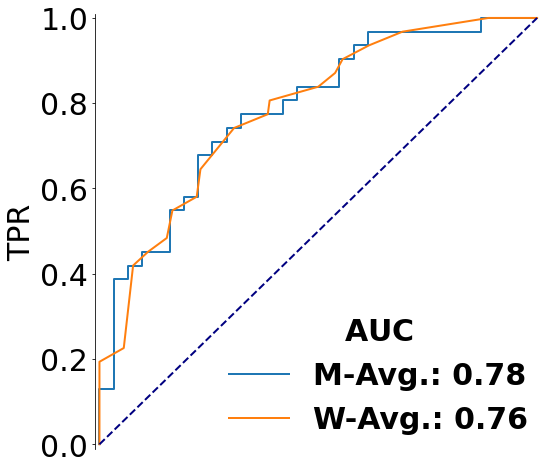

hypermutated (colon) 
 [0. 1.]


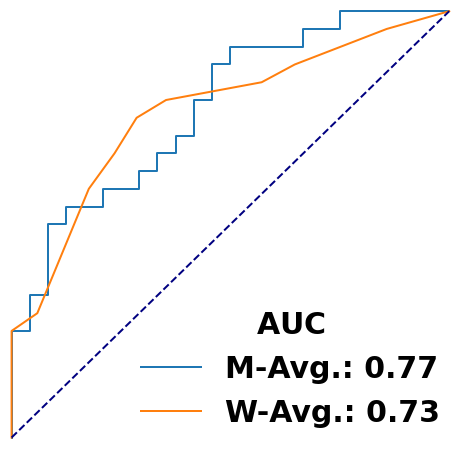

M_stage 
 ['m0' 'm1' 'mx']


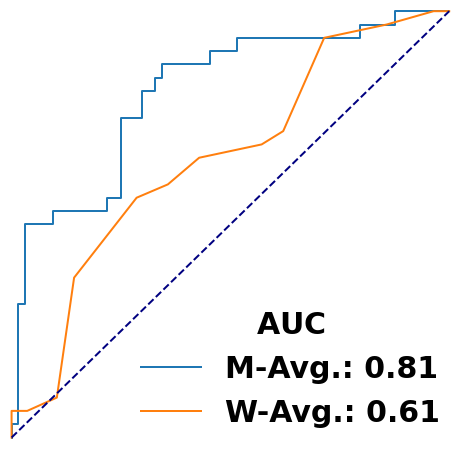

msi_status 
 ['Indeterminate' 'MSI-H' 'MSI-L' 'MSS']


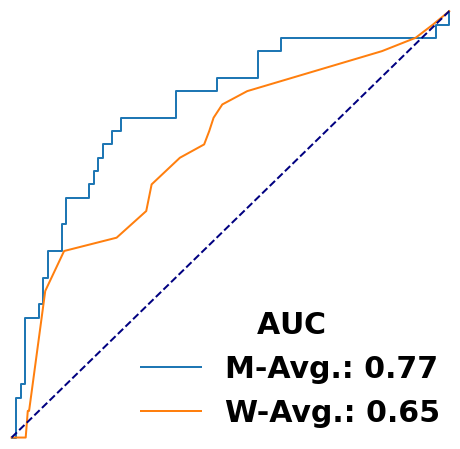

Proliferation 
 ['High' 'Low' 'Moderate']


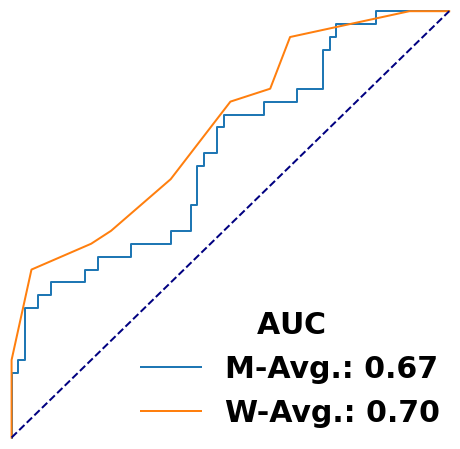

Wound Healing 
 ['High' 'Low' 'Moderate']


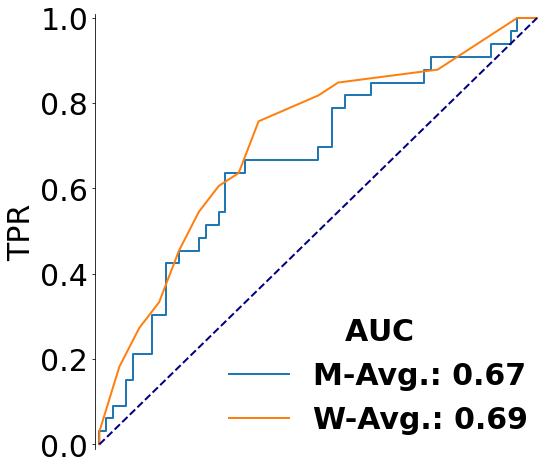

tumor_status 
 ['TUMOR FREE' 'WITH TUMOR']


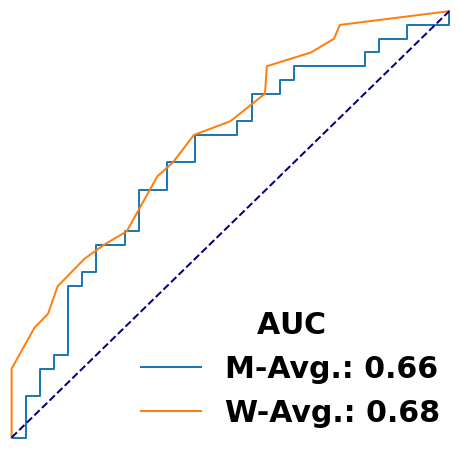

CTA Score 
 ['High' 'Low' 'Moderate']


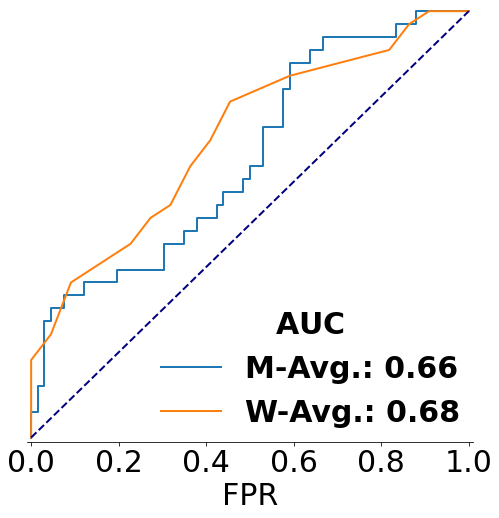

Aneuploidy Score 
 ['High' 'Low' 'Moderate']


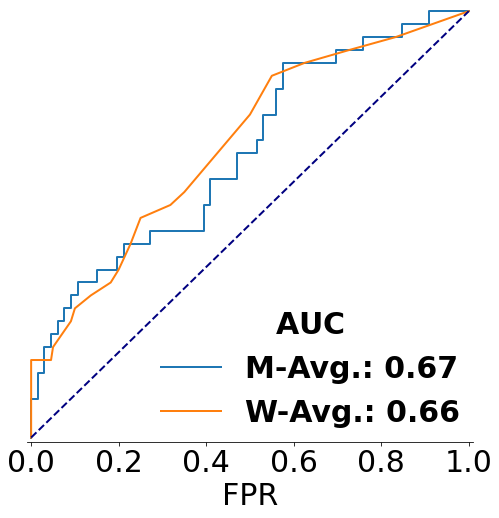

methylation_subtype 
 ['CIMP-H' 'CIMP-L' 'Cluster3' 'Cluster4']


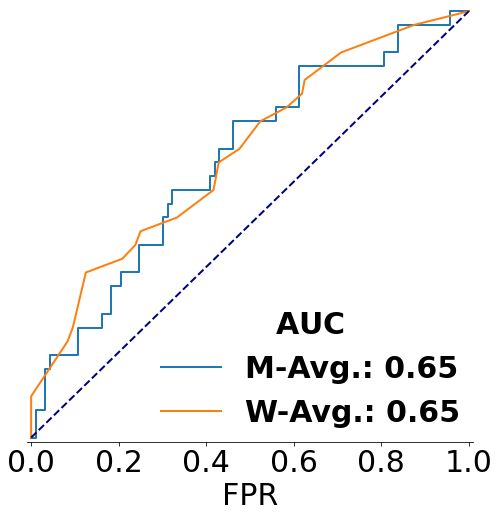

PFI.time (days) 
 ['High' 'Low' 'Moderate']


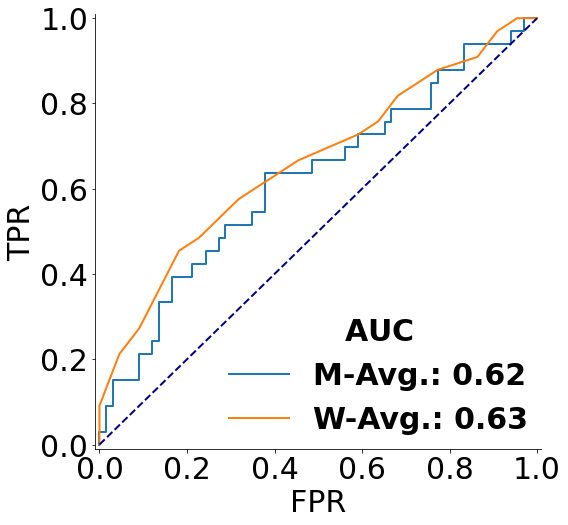

Fraction Altered 
 ['High' 'Low' 'Moderate']


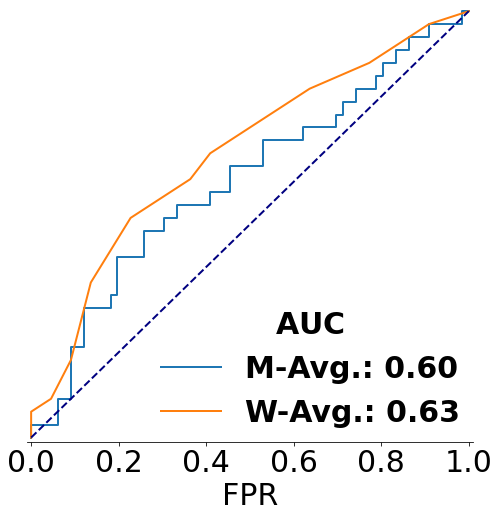

STAD
race 
 ['ASIAN' 'BLACK OR AFRICAN AMERICAN' 'WHITE']


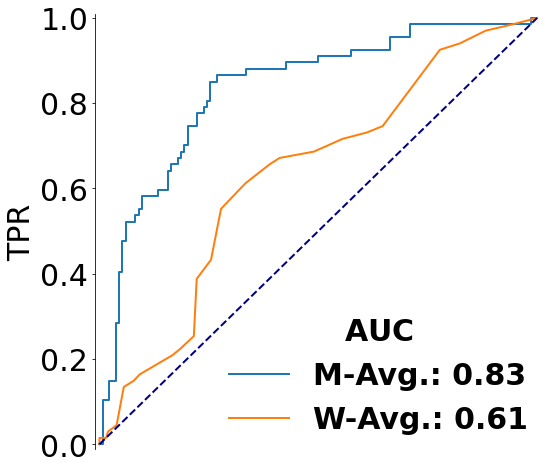

histological_grade 
 ['G1' 'G2' 'G3' 'GX']


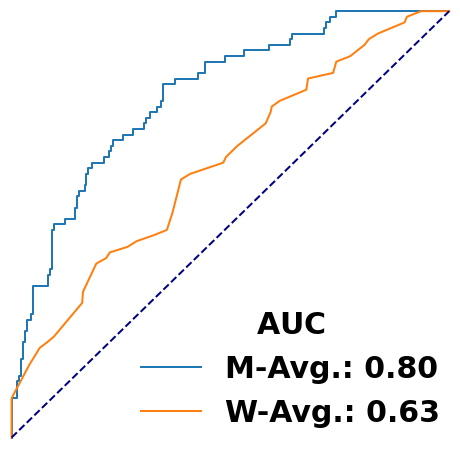

DSS 
 [0. 1.]


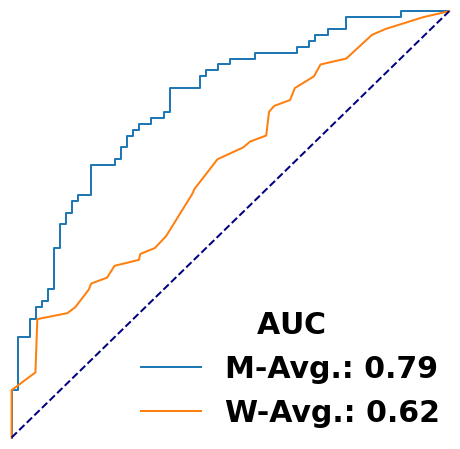

initial_pathologic_dx_year 
 ['High' 'Low' 'Moderate']


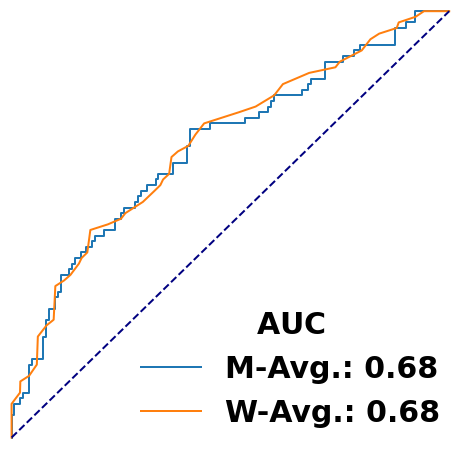

TCGA Subtype 
 ['GI.CIN' 'GI.EBV' 'GI.GS' 'GI.HM-SNV' 'GI.HM-indel']


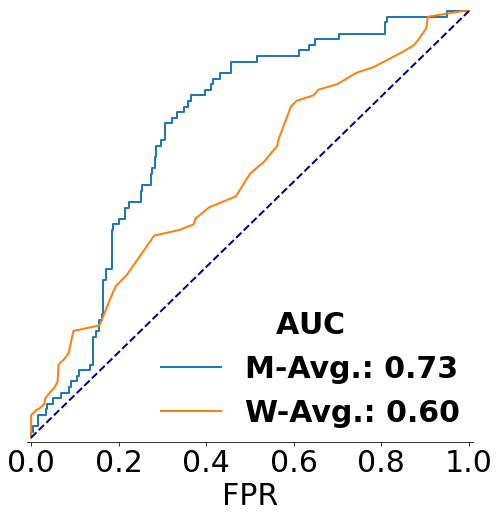

radiation_therapy 
 ['no' 'yes']


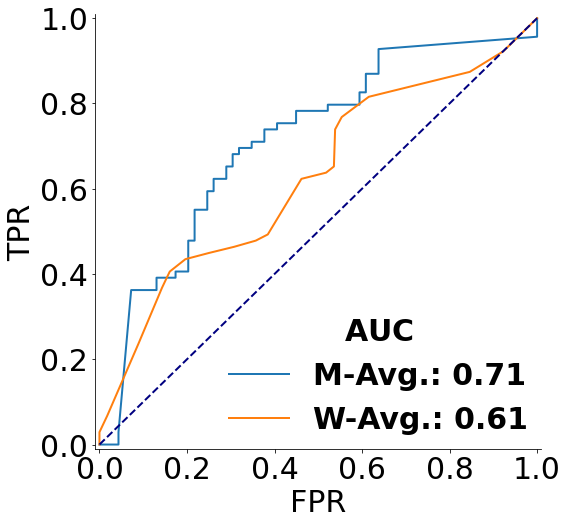

last_contact_days_to 
 ['High' 'Low' 'Moderate']


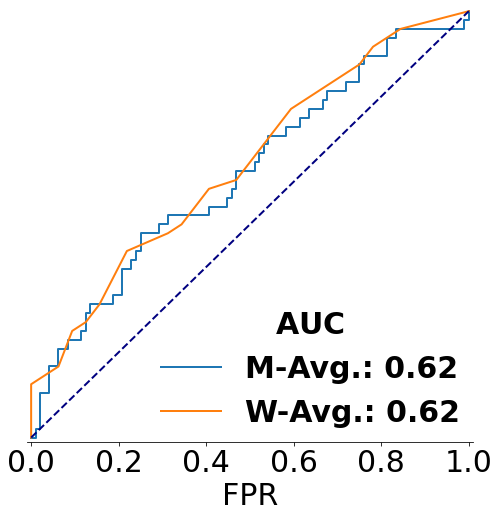

OS.time (days) 
 ['High' 'Low' 'Moderate']


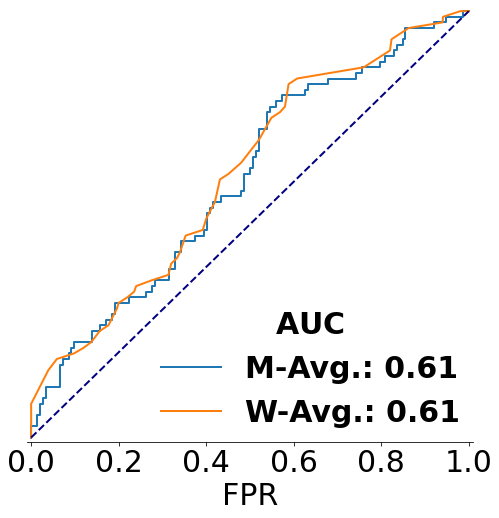

PFI.time (days) 
 ['High' 'Low' 'Moderate']


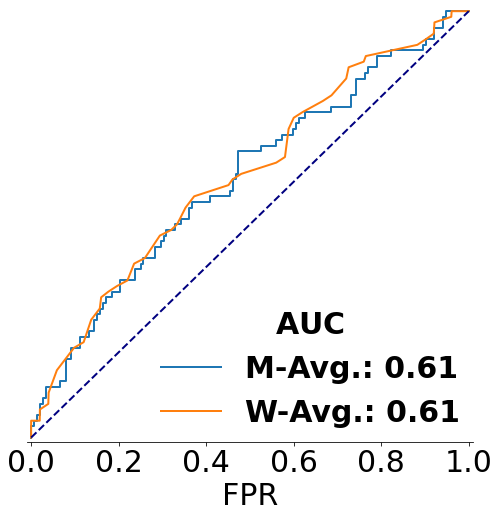

In [9]:
for CANCER in ['COAD', 'STAD']:
    print('=================================')
    print(CANCER)
    print('=================================')
    roc_curve_all(disease=CANCER, plot_axis='default')

### For website "x1y1"

In [37]:
def roc_curve_all(disease, fig_save_folder='./figures/ROC', variables=None, fontsize=30, bbox_to_anchor=(1.03, -0.03), 
                  plot_axis='x1y1', plot_num_per_row=5):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    import os

    pred_result_save_folder = './results/%s' % disease
    with open(os.path.join(pred_result_save_folder, '{}_prediction_result_dict.pkl'.format(disease)), 'rb') as f:
        prediction_result_dict = pickle.load(f)

    lrp_result_save_folder = './results/LRP/%s' % disease
    with open(os.path.join(lrp_result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)
    
    if variables is None:
        plot_var = lrp_result_dict['y_col_names']
    else:
        plot_var = variables
        
    n_row = np.ceil(len(plot_var)/plot_num_per_row)
    n_full_col = len(plot_var)%plot_num_per_row
       
    for idx, cov in enumerate(list(plot_var)):
        y_test_cov = prediction_result_dict['y_train_test'][cov][1]

        y_test = label_binarize(y_test_cov.values, classes=prediction_result_dict['classes'][cov])
        if y_test.shape[1]==1:
            y_test = np.hstack((1-y_test, y_test))
        y_score = prediction_result_dict['pred_proba'][cov].cpu().numpy()
        classes = prediction_result_dict['classes'][cov]
        print(cov, '\n', classes)
        
        # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        tt = dict()
        
        for i, c in enumerate(classes):
            if sum(y_test[:, i]) == 0:
                continue
            fpr[c], tpr[c], tt[c] = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[c] = auc(fpr[c], tpr[c])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

        # Then interpolate all ROC curves at this points with prevelence as weights
        mean_tpr = np.zeros_like(all_fpr)
        for i in classes:
            mean_tpr += np.sum(y_test_cov == i) * np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute weighted average AUC
        mean_tpr /= len(y_test_cov)
        
        mean_tpr = np.insert(mean_tpr, [0, len(mean_tpr)], [0., 1.])
        all_fpr = np.insert(all_fpr, [0, len(all_fpr)], [0., 1.])

        fpr["weighted"] = all_fpr
        tpr["weighted"] = mean_tpr
        roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])
        
        stored_auc = prediction_result_dict['auc'][cov]
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        lw = 2
        
#         import matplotlib
#         cmap = matplotlib.cm.get_cmap('Set1')

        plt.plot(
        fpr['micro'],
        tpr['micro'],
        lw=lw,
#         color=cmap(0),
        label=f"M-Avg.: {stored_auc[0]:0.2f}"
        )
        
        plt.plot(
        fpr['weighted'],
        tpr['weighted'],
        lw=lw,
#         color=cmap(1),
        label=f"W-Avg.: {stored_auc[1]:0.2f}"
        )
        legend_properties = {'weight':'bold', 'size':fontsize}
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        
        if plot_axis == 'default':
            if idx%plot_num_per_row == 0 and  idx//plot_num_per_row == n_row-1: axis = 'x1y1'
            elif idx%plot_num_per_row == 0: axis = 'x0y1'
            elif idx//plot_num_per_row == n_row-1: axis = 'x1y0'
            elif idx%plot_num_per_row > n_full_col-1  and idx//plot_num_per_row == n_row-2: axis = 'x1y0'
            else: axis = 'x0y0'
        elif plot_axis in ['x1y1', 'x0y1', 'x1y0', 'x0y0']:
            axis = plot_axis
        else:
            raise ValueError("Please choose a value for argument 'axis' among "\
                             "{'default', 'x1y1', 'x0y1', 'x1y0', 'x0y0'}!")
        
        if axis == 'x1y1':
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x0y1':
            ax.spines['bottom'].set_visible(False)
            
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("TPR", fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
        elif axis == 'x1y0':
            ax.spines['left'].set_visible(False)
            
            plt.xlabel("FPR", fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.ylabel("")
            plt.yticks([])
        elif axis == 'x0y0':
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
            plt.xlabel("")
            plt.xticks([])
            plt.ylabel("")
            plt.yticks([])
        
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        
        legend = plt.legend(loc='lower right', bbox_to_anchor=bbox_to_anchor, title=r'$\bf{AUC}$', 
                            frameon=False, prop=legend_properties)
        title = legend.get_title()
        title.set_fontsize(fontsize)
        plt.show()
        
        os.makedirs(f"{fig_save_folder}/{disease}", exist_ok=True)
        fig.savefig(f"{fig_save_folder}/{disease}/{cov}_{axis}.png", bbox_inches='tight')

tumor_status 
 ['TUMOR FREE' 'WITH TUMOR']


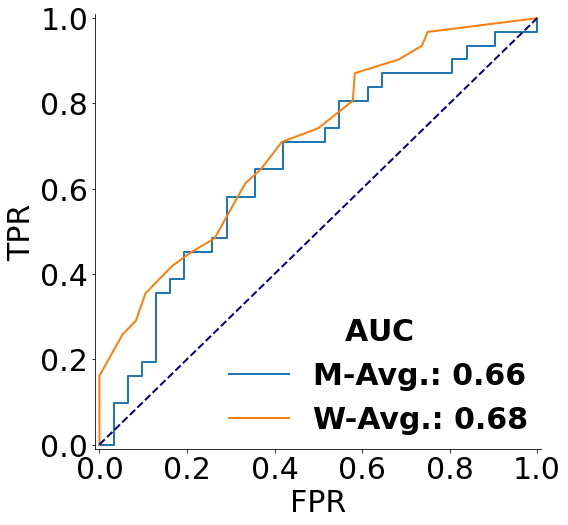

PFI.time (days) 
 ['High' 'Low' 'Moderate']


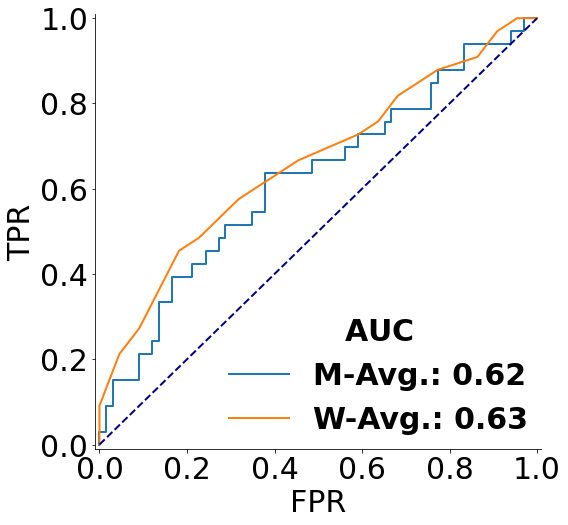

number_of_lymph_nodes 
 ['Min' 'Not Min']


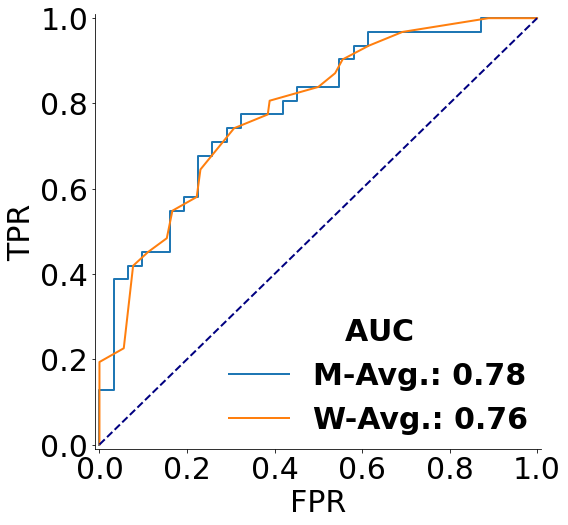

M_stage 
 ['m0' 'm1' 'mx']


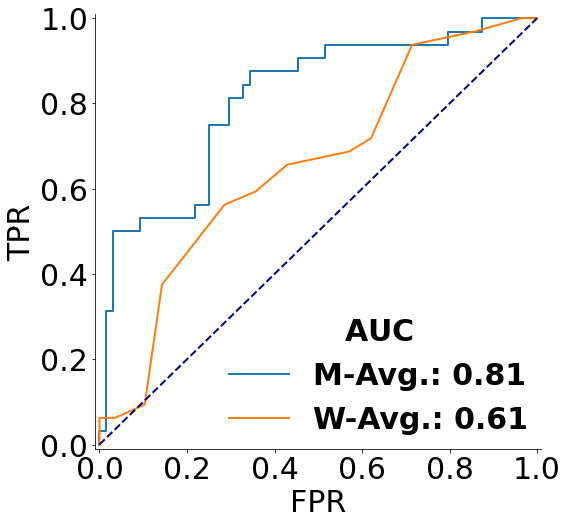

hypermutated (colon) 
 [0. 1.]


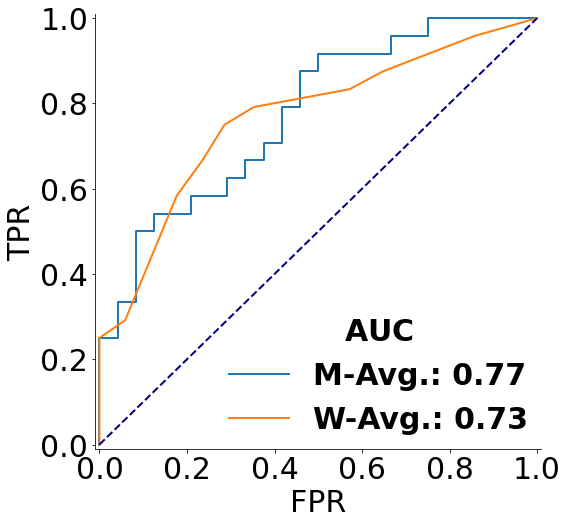

methylation_subtype 
 ['CIMP-H' 'CIMP-L' 'Cluster3' 'Cluster4']


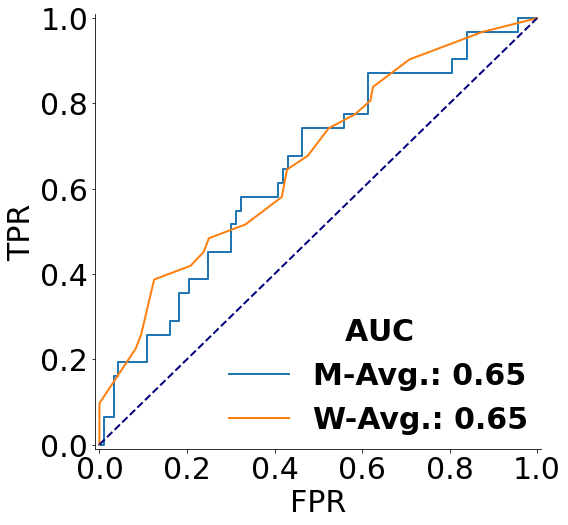

msi_status 
 ['Indeterminate' 'MSI-H' 'MSI-L' 'MSS']


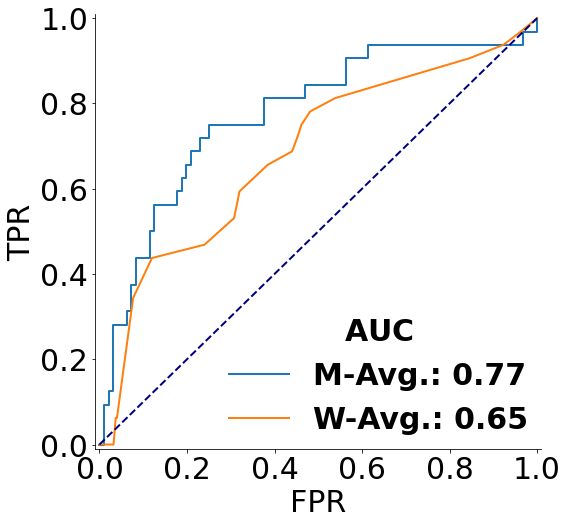

Proliferation 
 ['High' 'Low' 'Moderate']


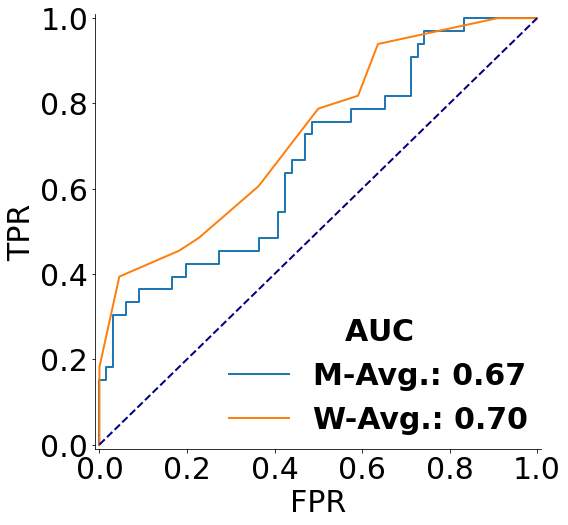

Wound Healing 
 ['High' 'Low' 'Moderate']


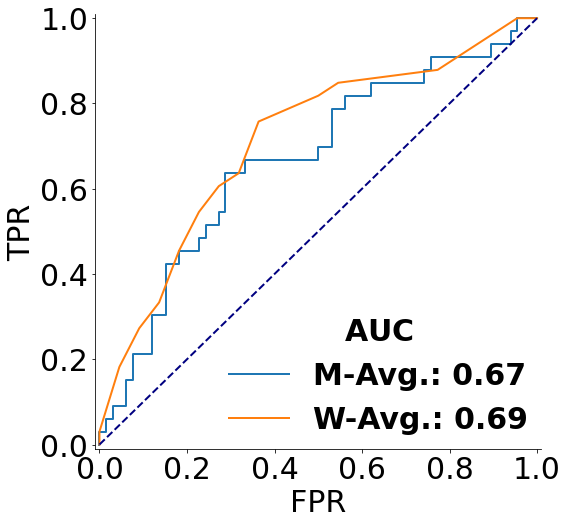

Fraction Altered 
 ['High' 'Low' 'Moderate']


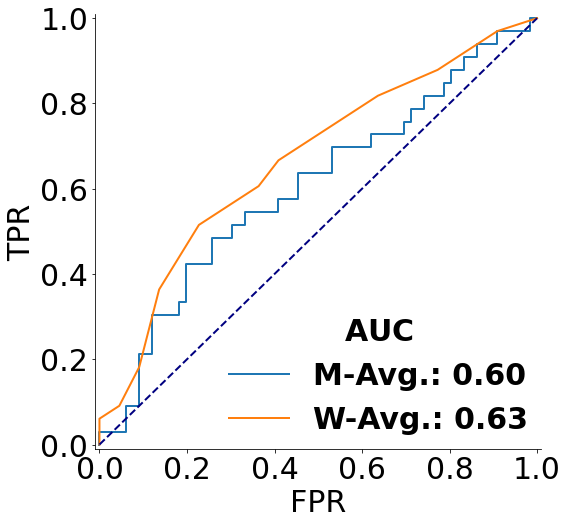

Aneuploidy Score 
 ['High' 'Low' 'Moderate']


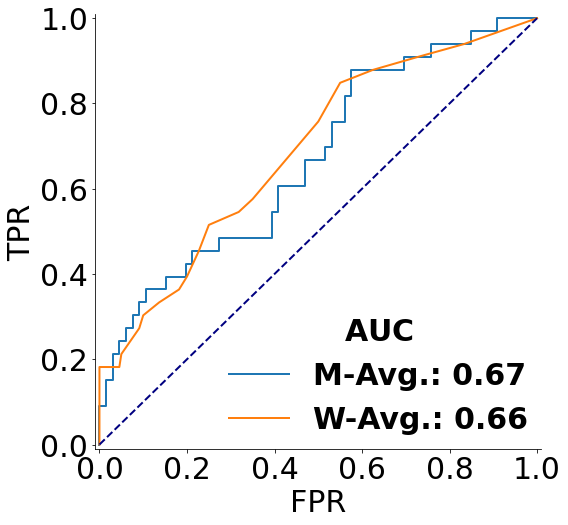

CTA Score 
 ['High' 'Low' 'Moderate']


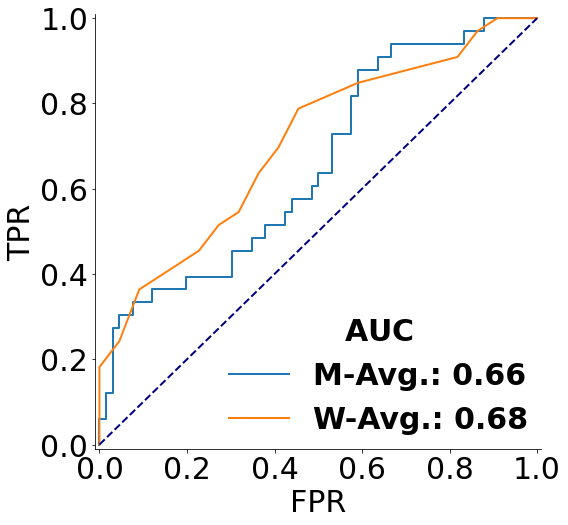

race 
 ['ASIAN' 'BLACK OR AFRICAN AMERICAN' 'WHITE']


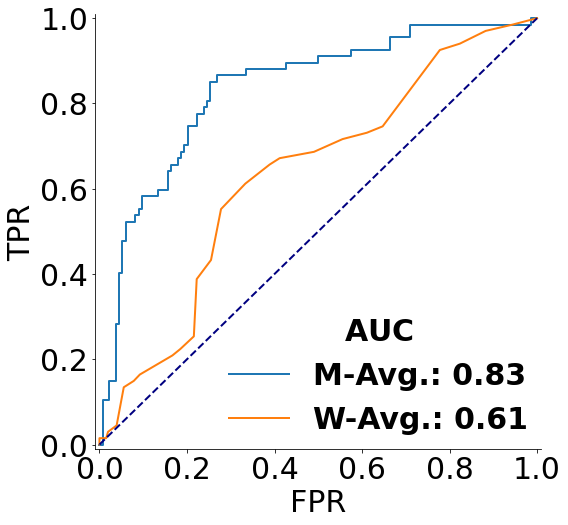

histological_grade 
 ['G1' 'G2' 'G3' 'GX']


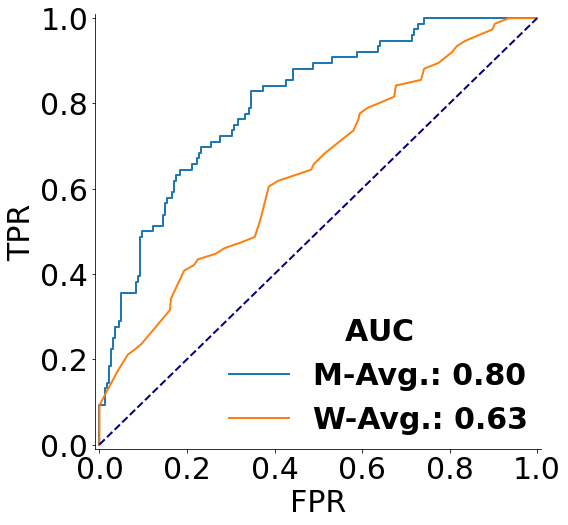

initial_pathologic_dx_year 
 ['High' 'Low' 'Moderate']


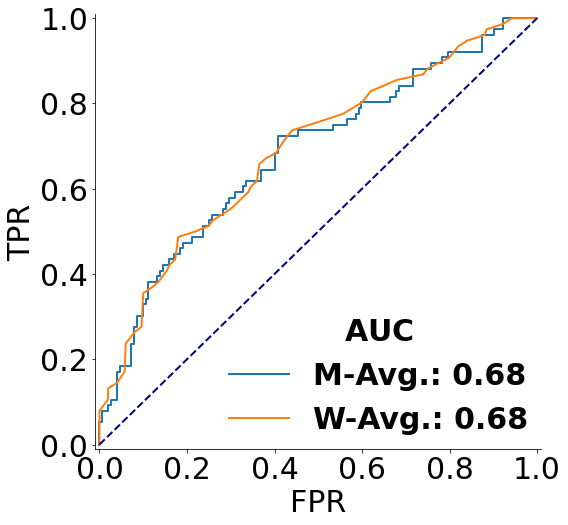

last_contact_days_to 
 ['High' 'Low' 'Moderate']


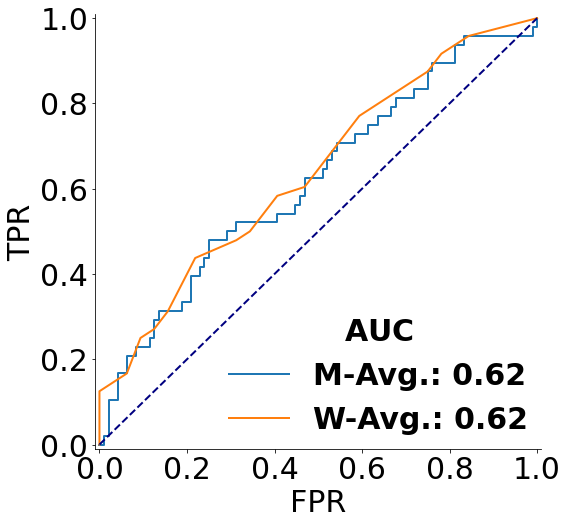

OS.time (days) 
 ['High' 'Low' 'Moderate']


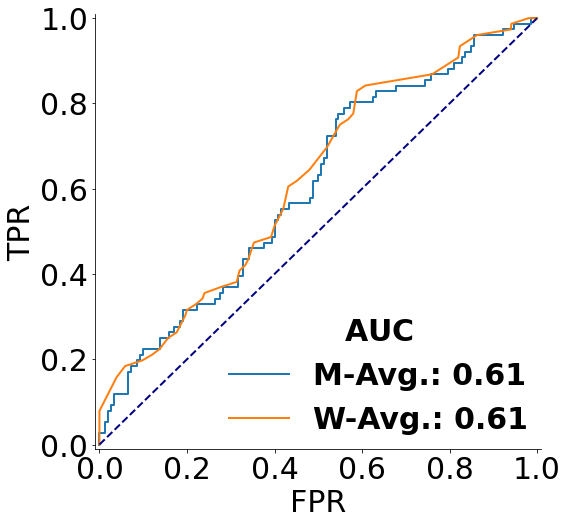

DSS 
 [0. 1.]


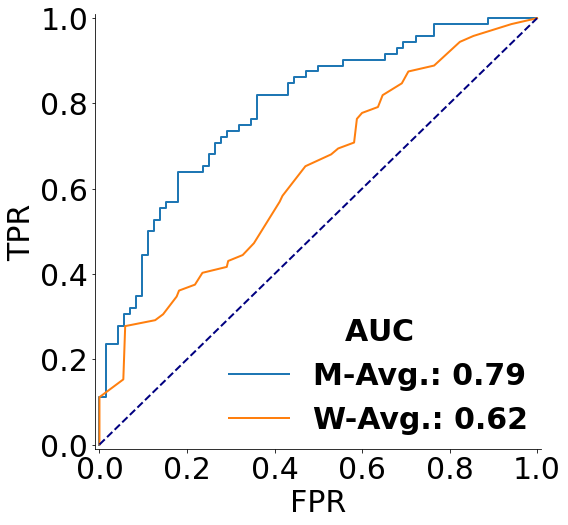

PFI.time (days) 
 ['High' 'Low' 'Moderate']


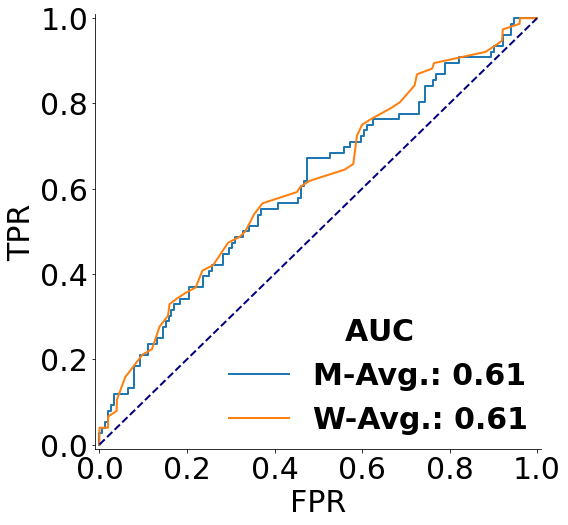

radiation_therapy 
 ['no' 'yes']


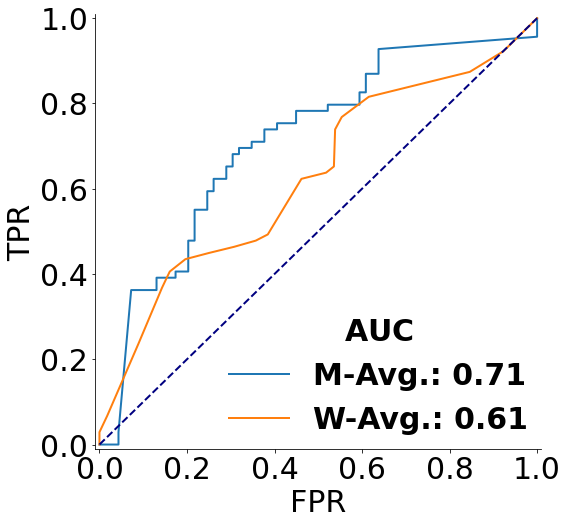

TCGA Subtype 
 ['GI.CIN' 'GI.EBV' 'GI.GS' 'GI.HM-SNV' 'GI.HM-indel']


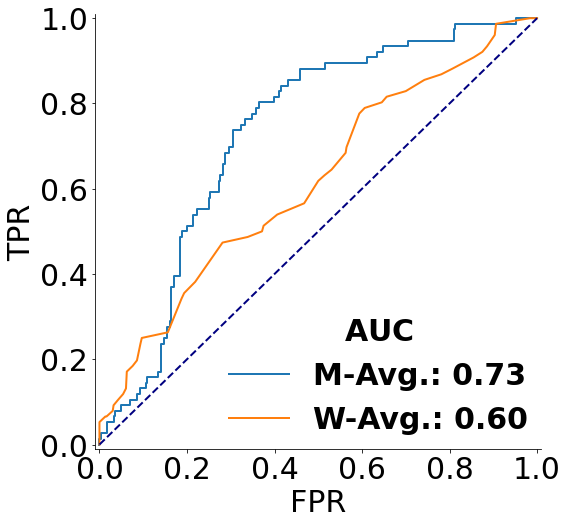

In [38]:
roc_curve_all(disease='COAD', fig_save_folder='./figures/web_ROC', plot_axis='x1y1')
roc_curve_all(disease='STAD', fig_save_folder='./figures/web_ROC', plot_axis='x1y1')

---

## Heatmap

In [34]:
def sort_influence(disease, save_folder='./', decreasing=True, covariate_list=None):
    with open(os.path.join(save_folder, f'results/LRP/{disease}/lrp_result_dict.pkl'), "rb") as f:
        lrp_result_dict = pickle.load(f)
    influence = lrp_result_dict['influence_by_microbe_all']
    row_names = lrp_result_dict['y_col_names'] if covariate_list is None else covariate_list
    column_names = pd.read_pickle(os.path.join(save_folder, 
                                               f'data/processed data/{disease}_microbiome_clean.pkl')).columns
    ### Sorted by col sum
    ascending_sort_idx_col = np.argsort(np.sum(influence, axis=0))
    sort_idx_col = ascending_sort_idx_col[::-1] if decreasing else ascending_sort_idx_col
    ### Sorted row by AUC scores
    sorted_auc_df = sorted_auc(disease, print_disease_name=False)
    sort_idx_row = np.array([np.where(rn == row_names)[0][0] for rn in sorted_auc_df['Covariate']])
    sorted_influence_df = pd.DataFrame(influence[sort_idx_row,:][:, sort_idx_col], 
                                columns = column_names[sort_idx_col], 
                                index = sorted_auc_df['Covariate'].values)
    return sorted_influence_df

In [35]:
def heatmap_influence(disease, influence_df, top_col_pct=0.05, plot=True, covariate_subset=None,
                      cmap="Blues", cbar=True, cmax=None, taxa_names=True, feature_names=True,
                      fontsize=16, font_scale=2.5, linewidths=0., horizontal=True, 
                      save=False, fig_save_folder='./figures'):
    
    import seaborn as sns
    taxa_name = list(influence_df.columns)
    genus_name = [tn.split('__')[-1] for tn in taxa_name]
    nona_idx = np.where(np.array(genus_name) != '')[0]
    genus_name_nona = np.array(genus_name)[nona_idx]
    
    influence_df_genus_lvl = influence_df.iloc[:, nona_idx]
    influence_df_genus_lvl.columns = list(genus_name_nona)
    
    n_col_selected = np.round(influence_df_genus_lvl.shape[1] * top_col_pct).astype(int)
    
    if covariate_subset is None:
        row_subset = influence_df_genus_lvl.index
    else:
        row_subset = covariate_subset
    
    influence_df_genus_lvl_marker = influence_df_genus_lvl.loc[row_subset, influence_df_genus_lvl.columns[:n_col_selected]]
    if top_col_pct==1.: 
        influence_df_genus_lvl_marker.to_csv(f'./results/LRP/{disease}/sorted_influence_df.csv')
    else:
        influence_df_genus_lvl_marker.to_csv(f'./results/LRP/{disease}/sorted_influence_df_pct{str(int(top_col_pct*100))}.csv')

    if plot:
        if horizontal:
            figheight = len(row_subset)*2-2
            figwidth = n_col_selected*2
            fig, ax = plt.subplots(figsize=(figwidth, figheight))
            print(influence_df_genus_lvl_marker.T.shape)
            hm = sns.heatmap(influence_df_genus_lvl_marker, linewidths=linewidths, cbar=cbar, cbar_kws={"pad":0.01}, 
                            cmap=cmap, vmin=0, vmax=cmax)
            if taxa_names: hm.set_xticklabels(hm.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor', fontsize=fontsize)
            else: hm.set_xticklabels([])
            if feature_names: hm.set_yticklabels(hm.get_yticklabels(), fontsize=fontsize, rotation=0, ha='right')
            else: hm.set_yticklabels([])
        else:
            figwidth = len(row_subset)*2-2
            figheight = n_col_selected*2
            fig, ax = plt.subplots(figsize=(figwidth, figheight))
            # Use transposed DF
            print(influence_df_genus_lvl_marker.T.shape)
            hm = sns.heatmap(influence_df_genus_lvl_marker.T, linewidths=linewidths, cbar=cbar, cbar_kws={"pad":0.01, "orientation":"horizontal"}, 
                            cmap=cmap, vmin=0, vmax=cmax)
            if taxa_names: hm.set_yticklabels(hm.get_yticklabels(), rotation=30, ha='right', rotation_mode='anchor', fontsize=fontsize+10)
            else: hm.set_yticklabels([])
            if feature_names: hm.set_xticklabels(hm.get_xticklabels(), fontsize=fontsize-5, rotation=30, ha='left')
            else: hm.set_xticklabels([])
        # want a more natural, table-like display
        ax.tick_params(top = False, labelbottom=False, labeltop=True)
        sns.set(font_scale=font_scale)
        if cmax is None: cmax = np.max(np.array(influence_df).reshape(-1))
        hm.figure.axes[-1].yaxis.label.set_size(40)
        # use matplotlib.colorbar.Colorbar object
        if cbar==True:
            cbar = hm.collections[0].colorbar
            cbar.ax.tick_params(labelsize=40)
        plt.show()
    
        if save:
            os.makedirs(f"{fig_save_folder}", exist_ok=True)
            fig.savefig(f"{fig_save_folder}/biomarker_heatmap_{disease}.pdf", bbox_inches='tight')
            fig.savefig(f"{fig_save_folder}/biomarker_heatmap_{disease}.png", bbox_inches='tight')
    
    return influence_df_genus_lvl_marker

In [52]:
COAD_sorted_influence_df = sort_influence('COAD')
np.max(np.array(COAD_sorted_influence_df).reshape(-1))

155.26022

(62, 12)


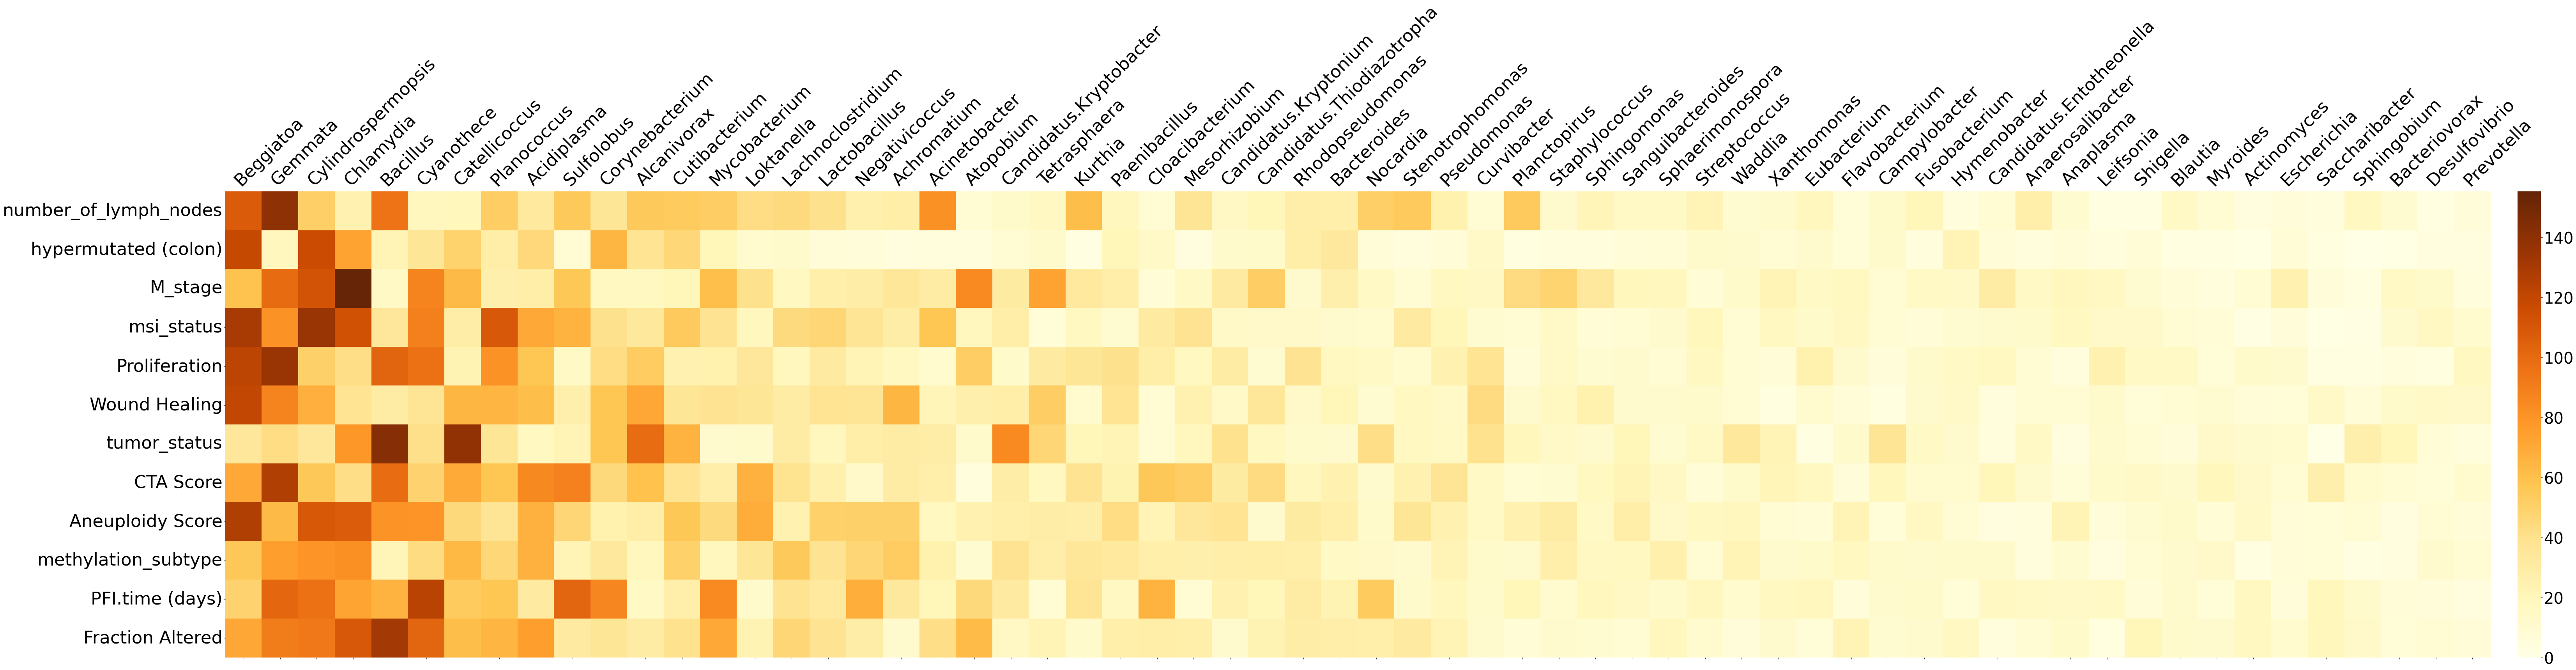

In [37]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap="YlOrBr", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=False, taxa_names=True, fontsize=45,
                                                    horizontal=True)

(62, 12)


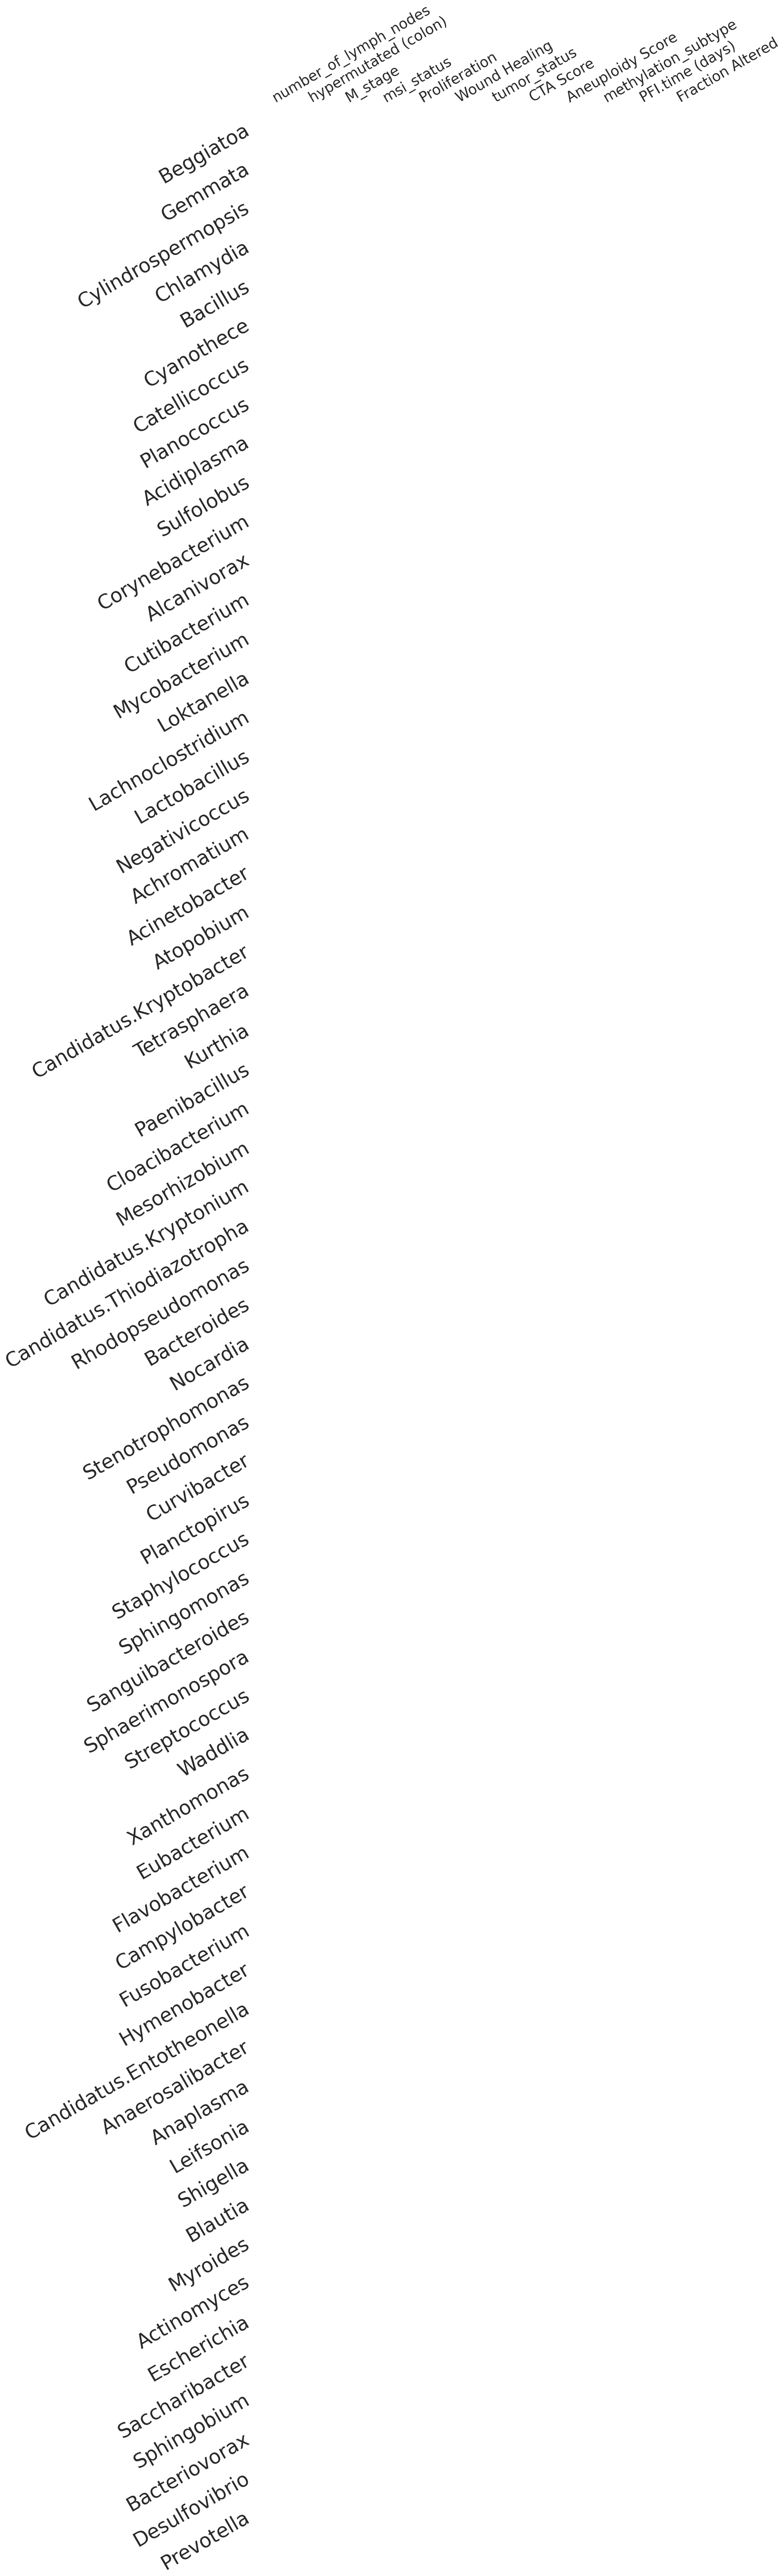

In [53]:
from matplotlib.colors import ListedColormap
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap=ListedColormap(['white']), #"Blues", "YlOrBr", "Reds"
                                                    cbar=False, top_col_pct=0.05, save=True, taxa_names=True, fontsize=45,
                                                    horizontal=False, feature_names=True)

(62, 12)


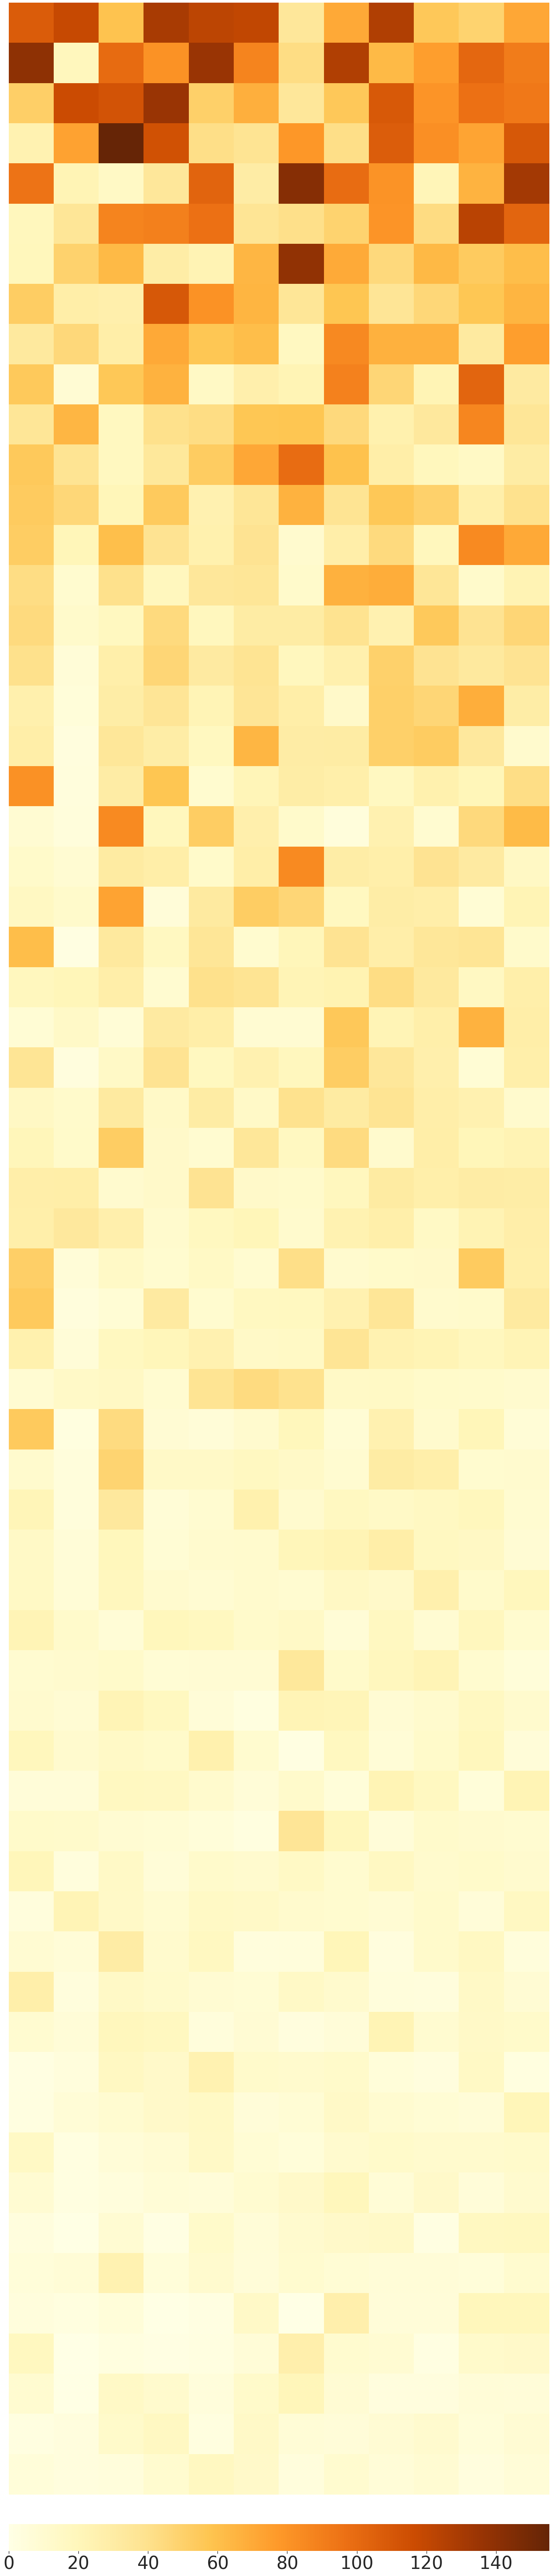

In [54]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, cmap="YlOrBr", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=True, taxa_names=False, fontsize=45,
                                                    horizontal=False, feature_names=False)

In [49]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, top_col_pct=0.01, plot=False)

In [50]:
COAD_sorted_influence_df_subset = heatmap_influence('COAD', COAD_sorted_influence_df, top_col_pct=1., plot=False)

In [51]:
COAD_sorted_influence_df_subset

Beggiatoa     Gemmata  Cylindrospermopsis   Chlamydia  \
number_of_lymph_nodes  107.733078  139.492920           51.152977   24.791399   
hypermutated (colon)   118.869415   19.368832          116.452881   73.448418   
M_stage                 58.444477   99.733284          112.298538  155.260223   
msi_status             130.217422   80.665932          135.652115  113.631172   
Proliferation          122.209648  135.609573           50.572060   41.328465   
Wound Healing          120.372581   87.398315           67.782288   37.987576   
tumor_status            34.631622   42.473686           34.727783   78.790230   
CTA Score               70.561836  126.783539           55.209351   41.633045   
Aneuploidy Score       127.295853   63.014923          109.301842  107.333183   
methylation_subtype     55.698082   75.319893           80.031265   82.180672   
PFI.time (days)         49.027214  101.310577           96.581703   72.303139   
Fraction Altered        71.452942   91.387238           92.975266  109.848709   

                         Bacillus  Cyanothece  Catellicoccus  Planococcus  \
number_of_lymph_nodes   95.780937   19.005728      19.576118    52.456970   
hypermutated (colon)    22.592962   36.204750      49.453011    29.069174   
M_stage                 15.305030   87.470856      62.522018    27.175623   
msi_status              34.974598   89.454254      29.244299   110.088684   
Proliferation          103.596115   96.687607      23.415003    81.221268   
Wound Healing           30.022299   37.109970      64.452957    65.212822   
tumor_status           142.766342   41.045681     138.332214    35.989162   
CTA Score               99.366646   48.519127      70.277740    57.102814   
Aneuploidy Score        80.177597   80.010788      44.998779    36.965370   
methylation_subtype     21.770084   43.413204      63.652550    46.511196   
PFI.time (days)         65.952675  123.484222      53.501499    56.891365   
Fraction Altered       131.673050  102.531036      60.765236    64.917786   

                       Acidiplasma  Sulfolobus  ...  Tatumella  \
number_of_lymph_nodes    33.040672   54.725071  ...   0.056572   
hypermutated (colon)     45.886082    8.686132  ...   0.021461   
M_stage                  28.780151   55.989666  ...   0.018317   
msi_status               70.629341   66.623482  ...   0.005519   
Proliferation            56.952267   15.687149  ...   0.054330   
Wound Healing            60.758461   27.137373  ...   0.058868   
tumor_status             17.406746   22.753098  ...   0.060213   
CTA Score                85.287308   88.914642  ...   0.186519   
Aneuploidy Score         67.016060   47.234692  ...   0.059582   
methylation_subtype      67.167168   22.590904  ...   0.094723   
PFI.time (days)          32.718788  102.786087  ...   0.051799   
Fraction Altered         75.520699   31.721140  ...   0.047003   

                       Aneurinibacillus  Candidatus.Nitrosoarchaeum  \
number_of_lymph_nodes          0.069003                    0.061577   
hypermutated (colon)           0.047328                    0.023522   
M_stage                        0.012172                    0.000723   
msi_status                     0.014275                    0.000583   
Proliferation                  0.067902                    0.066848   
Wound Healing                  0.053530                    0.049988   
tumor_status                   0.054956                    0.057242   
CTA Score                      0.139563                    0.177710   
Aneuploidy Score               0.055345                    0.058684   
methylation_subtype            0.088965                    0.064423   
PFI.time (days)                0.059513                    0.091503   
Fraction Altered               0.052039                    0.059876   

                       Kitasatospora  Phocaeicola  Halobacillus  Methylomonas  \
number_of_lymph_nodes       0.053486     0.061145      0.066120      0.053250   
hypermutated (colon)   

---

In [36]:
STAD_sorted_influence_df = sort_influence('STAD')

(62, 9)


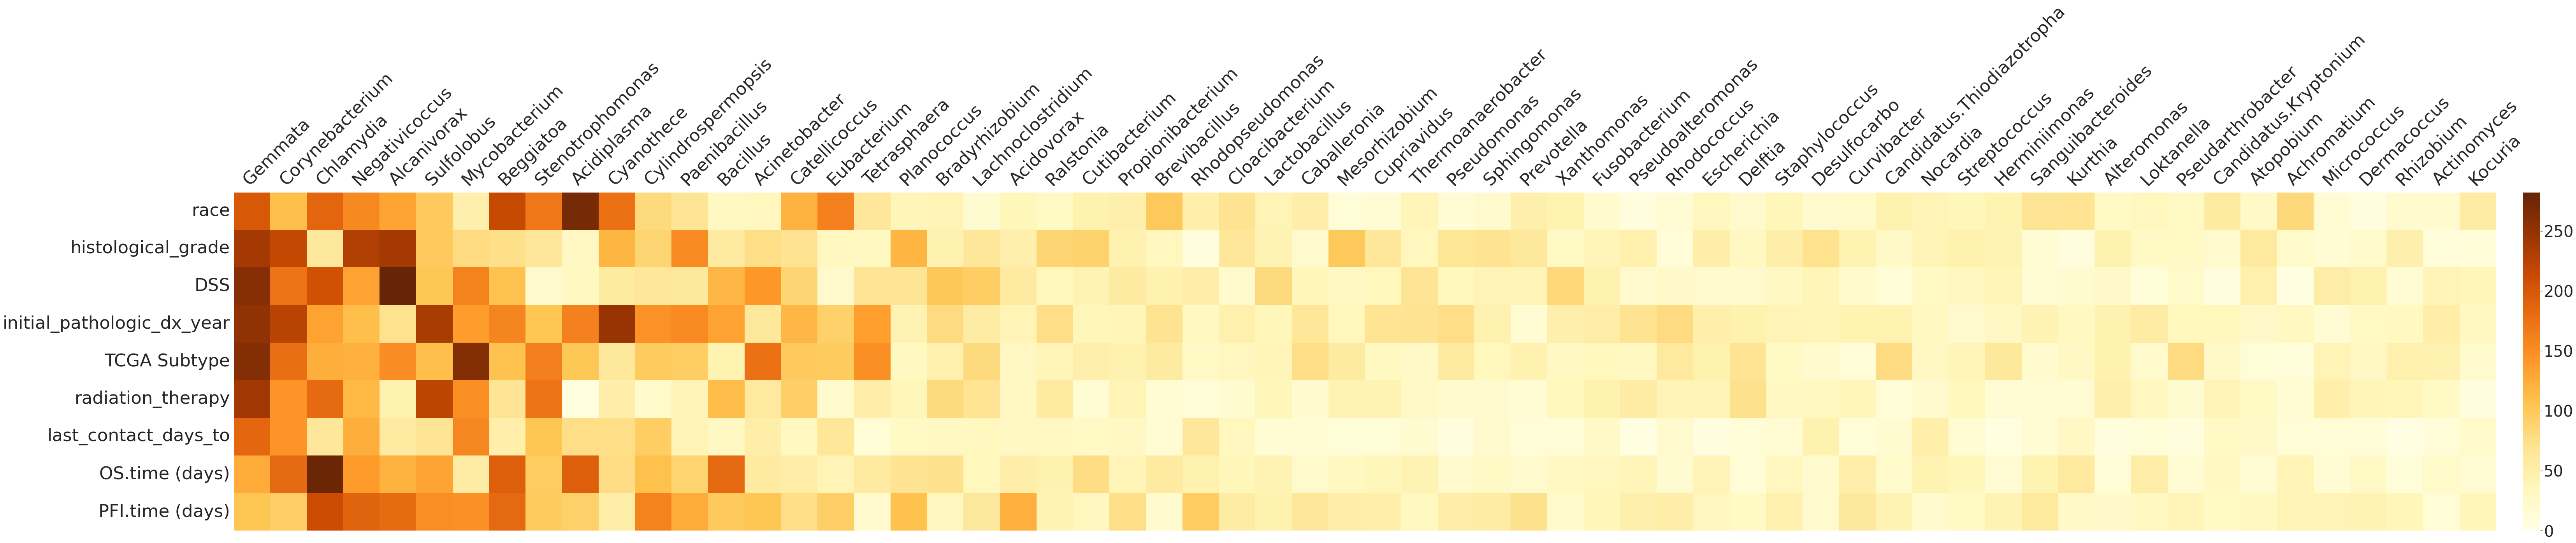

In [53]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap="YlOrBr", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=False, taxa_names=True, fontsize=45,
                                                    horizontal=True)

(62, 9)


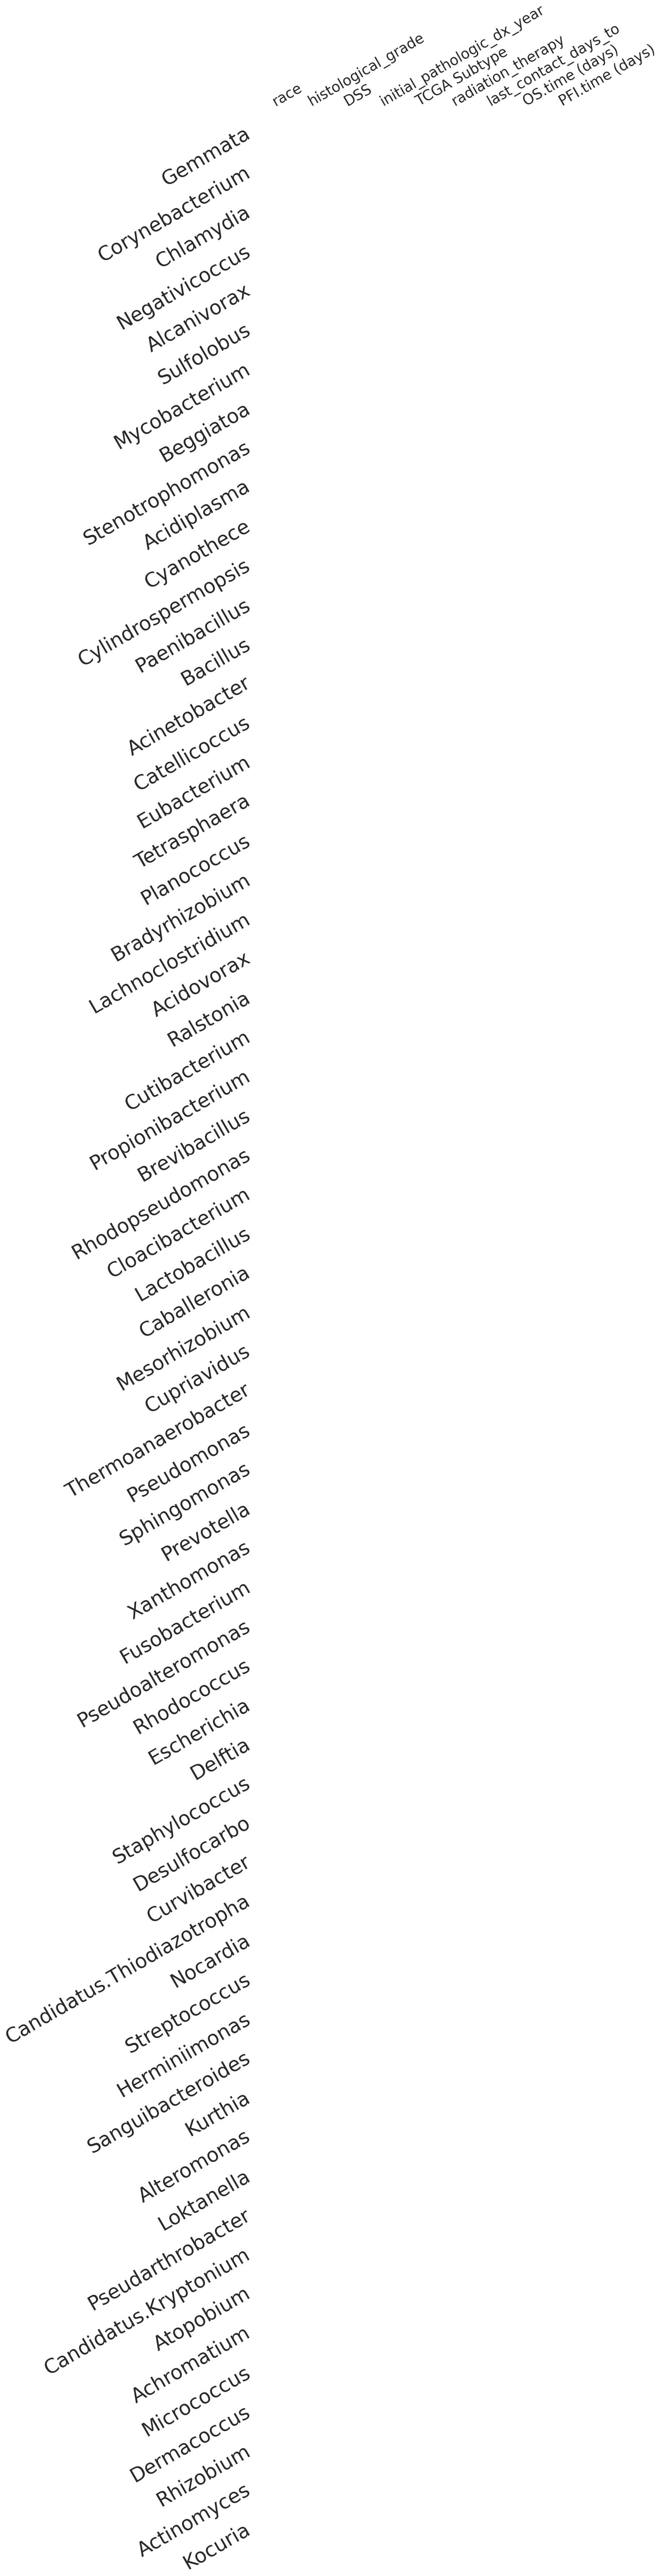

In [39]:
from matplotlib.colors import ListedColormap
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap=ListedColormap(['white']), #"Blues", "YlOrBr", "Reds"
                                                    cbar=False, top_col_pct=0.05, save=True, taxa_names=True, fontsize=45,
                                                    horizontal=False, feature_names=True)

(62, 9)


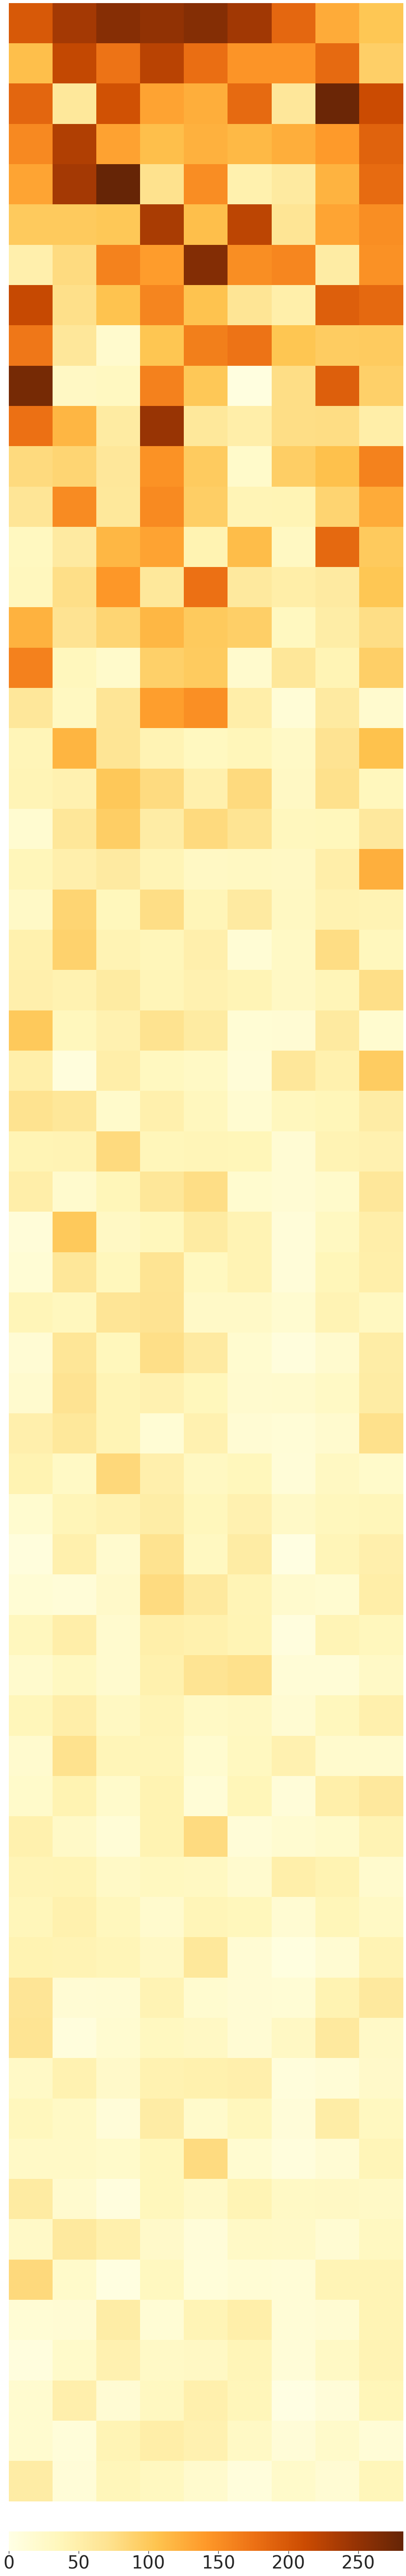

In [38]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, cmap="YlOrBr", #"Blues", "YlOrBr", "Reds"
                                                    cbar=True, top_col_pct=0.05, save=True, taxa_names=False, fontsize=45,
                                                    horizontal=False, feature_names=False)

In [55]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, top_col_pct=0.01, plot=False)

In [56]:
STAD_sorted_influence_df_subset = heatmap_influence('STAD', STAD_sorted_influence_df, top_col_pct=1., plot=False)

In [57]:
STAD_sorted_influence_df_subset

Gemmata  Corynebacterium   Chlamydia  \
race                        199.509598       109.379265  185.288071   
histological_grade          238.880402       217.616394   62.125008   
DSS                         259.571716       174.023941  206.251999   
initial_pathologic_dx_year  251.523178       224.446457  132.674408   
TCGA Subtype                260.730896       177.888855  124.137611   
radiation_therapy           240.819138       145.101303  182.012177   
last_contact_days_to        185.021210       145.440018   63.177040   
OS.time (days)              125.891632       182.030777  278.146118   
PFI.time (days)             102.738670        93.478683  212.218887   

                            Negativicoccus  Alcanivorax  Sulfolobus  \
race                            154.493790   132.225830   99.027168   
histological_grade              231.193039   238.203125   99.083984   
DSS                             133.941223   282.220734  101.817429   
initial_pathologic_dx_year      109.795784    71.680946  234.835892   
TCGA Subtype                    121.532547   151.640244  109.423637   
radiation_therapy               115.322746    46.779621  222.371490   
last_contact_days_to            123.576683    58.808674   67.845207   
OS.time (days)                  140.196075   119.175713  131.965515   
PFI.time (days)                 188.529083   181.677505  150.493271   

                            Mycobacterium   Beggiatoa  Stenotrophomonas  \
race                            49.495049  215.714111        170.483429   
histological_grade              80.191780   74.243172         63.904518   
DSS                            160.497467  106.479416         21.146118   
initial_pathologic_dx_year     138.700470  158.505325        104.532318   
TCGA Subtype                   261.825348  105.881660        163.912460   
radiation_therapy              150.852356   68.246300        173.161819   
last_contact_days_to           157.010147   50.516052        104.506439   
OS.time (days)                  55.469971  192.334869         96.410950   
PFI.time (days)                147.861282  184.044662         97.069786   

                            Acidiplasma  ...  Collimonas  Renibacterium  \
race                         270.146332  ...    0.000076       0.000207   
histological_grade            29.300152  ...    0.000056       0.000084   
DSS                           31.013762  ...    0.000103       0.000130   
initial_pathologic_dx_year   161.037247  ...    0.002006       0.001754   
TCGA Subtype                 101.742416  ...    0.000198       0.000272   
radiation_therapy              5.916467  ...    0.000139       0.000218   
last_contact_days_to          76.807411  ...    0.029808       0.028628   
OS.time (days)               192.379959  ...    0.001097       0.001073   
PFI.time (days)               91.981178  ...    0.001511       0.002079   

                            Acidiphilium  Trichodesmium  Hapalosiphon  \
race                            0.000391       0.000712      0.000117   
histological_grade              0.000105       0.000191      0.000089   
DSS                             0.000133       0.000268      0.000101   
initial_pathologic_dx_year      0.001872       0.002121      0.002859   
TCGA Subtype                    0.000294       0.000532      0.000242   
radiation_therapy               0.000122       0.000203      0.000186   
last_contact_days_to            0.027740       0.025962      0.026669   
OS.time (days)                  0.001503       0.001002      0.001134   
PFI.time (days)                 0.001330       0.002192      0.001069   

                              Enorma  Sporosarcina  Roseofilum  Oceanithermus  \
race                        0.000303      0.000092    0.000106       0.000019   
histological_grade          0.000117      0.000069    0.000027       0.000177   
DSS                         0.000209      0.000113    0.000062       0.000131   
initial_pathologic_dx_year  0.002407      0.001925  

---
## Save LRP results seperately

In [ ]:
def save_data_n_lrp(disease, save_folder='./', data_save_folder='../data/saved_data'):
    clinical_variables_disease_microbiome_clean = \
        pd.read_pickle('./data/processed data/{}_clinical_variables_disease_microbiome_clean.pkl'.format(disease))
    X_microbiome = pd.read_pickle('./data/processed data/{}_microbiome_clean.pkl'.format(disease))
    col_idx = clinical_variables_disease_microbiome_clean.shape[1] - X_microbiome.shape[1] - 3 - 5
    y_clinical_all = clinical_variables_disease_microbiome_clean.iloc[:,2:col_idx]
    data_save_folder1 = os.path.join(data_save_folder, f'{disease}')
    os.makedirs(data_save_folder1, exist_ok=True)
    X_microbiome.to_csv(os.path.join(data_save_folder1, 'X_microbiome.csv'))
    y_clinical_all.to_csv(os.path.join(data_save_folder1, 'y_clinical_all_cols.csv'))
    
    import pickle
    result_save_folder = os.path.join(save_folder, 'results/LRP/{}'.format(disease))
    os.makedirs(result_save_folder, exist_ok=True)
    with open(os.path.join(result_save_folder, 'lrp_result_dict.pkl'.format(disease)), "rb") as f:
        lrp_result_dict = pickle.load(f)
    
    R_0_clinical_all = lrp_result_dict['R_0_clinical_all']
    y_col_names = lrp_result_dict['y_col_names']
    
    for i, col in enumerate(y_col_names):
        classifier, optimizer, hist, X_test, y_test_le, classes, X_nonan, y_nonan_disc = \
            load_model(X=X_microbiome, y=y_clinical_all[col],
                       disease=disease, dropout_rate=0.4, weight_decay=0.1)
        R_0_df = pd.DataFrame(R_0_clinical_all[i], index=X_nonan.index, columns=X_nonan.columns)
        data_save_folder2 = os.path.join(data_save_folder, f'{disease}/{col}')
        os.makedirs(data_save_folder2, exist_ok=True)
        R_0_df.to_csv(os.path.join(data_save_folder2, 'R_0.csv'))
        X_nonan.to_csv(os.path.join(data_save_folder2, 'X_microbiome_nonan.csv'))
        

In [ ]:
save_data_n_lrp('COAD')
save_data_n_lrp('STAD')